# Nature Communications 2019 QE TMT Re-analysis

### Analysis performed by Phil Wilmarth

### 20190408

This is re-analysis of the data from "Proteogenomics and Hi-C reveal transcriptional dysregulation in high hyperdiploid childhood acute lymphoblastic leukemia" published in [Nature Communications April 3, 2019](https://www.nature.com/articles/s41467-019-09469-3#Abs1).

The paper is comparing samples from pediatric B-cell precursor acute lymphoblastic leukemia (BCP ALL) that were labeled with 10-plex TMT and analyzed on a Q-Exactive instrument. There were two leukemia conditions: high hyperdiploid (18 samples) and diploid/near-diploid ETV6/RUNX1-positive cases (9 samples). Samples were allocated in a balanced design with 6 and 3 samples per 10-plex, respectively. A pooled standard sample was also created and added to each plex (131N channel).

Digestion was via an eFASP protocol, peptide cleanup with an sp3 method, and TMT labeling was according to manufacturer's recommendations.

Each plex was first separated into 72 fractions by isoelectric point and each fraction run in a 60-min RP gradient. The QE was run in a top-10 mode at 70K resolution. MS2 HCD scans were acquired at 35K resolution.

---

- [Overview](#overview) 
- [R libraries and data loading](#load) 
- [IRS check](#irs_check) 
- [Load edgeR data structures](#load_edger) 
- [Normalization](#norm_check) 
- [HeH versus ETV6_RUNX1](#HeH) 
 

---

## Overview <a name="overview"></a>

Peptides and proteins were identified using Comet and the PAW pipeline. A wider 1.25 Da parent ion mass tolerance was used, TMT labels and alkylated cysteine were specified as static modifications, oxidation of methionine was specified as a variable modification, trypsin enzyme specificity was used, and a canonical UniProt reference human protein database was used. Fragment ion tolerance was set for high resolution MS2: 0.02 Da, offset of 0.0. Confident peptide identifications were obtained using accurate mass conditional score histograms, the target/decoy method, and the protein inference used basic parsimony principles. 

The PAW pipeline was used to infer proteins, perform homologous protein grouping, establish peptide uniqueness to the inferred proteins, and sum unique PSM reporter ions into protein intensity totals.

Results tables were filtered to remove common contaminants and the protein intensity tables were saved as tab-delimited text files for reading by the scripts below. Normalizations and statistical testing were performed using the Bioconductor package edgeR as detailed in the steps below. A Jupyter notebook with an R kernel was used to execute R commands and visualize the results. 

> Thompson, A., Schäfer, J., Kuhn, K., Kienle, S., Schwarz, J., Schmidt, G., Neumann, T. and Hamon, C., 2003. Tandem mass tags: a novel quantification strategy for comparative analysis of complex protein mixtures by MS/MS. Analytical chemistry, 75(8), pp.1895-1904.

> Wilmarth, P.A., Riviere, M.A. and David, L.L., 2009. Techniques for accurate protein identification in shotgun proteomic studies of human, mouse, bovine, and chicken lenses. Journal of ocular biology, diseases, and informatics, 2(4), pp.223-234.

> Gentleman, R.C., Carey, V.J., Bates, D.M., Bolstad, B., Dettling, M., Dudoit, S., Ellis, B., Gautier, L., Ge, Y., Gentry, J. and Hornik, K., 2004. Bioconductor: open software development for computational biology and bioinformatics. Genome biology, 5(10), p.R80.

> Robinson, M.D., McCarthy, D.J. and Smyth, G.K., 2010. edgeR: a Bioconductor package for differential expression analysis of digital gene expression data. Bioinformatics, 26(1), pp.139-140.

> www.jupyter.org

## Load the necessary libraries here <a name="load"></a>

In [1]:
# library imports
library(tidyverse)
library(scales)
library(limma)
library(edgeR)
library(psych)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor


Attaching package: ‘psych’

The following objects are masked from ‘package:scales’:

    alpha, rescale

The following objects are masked from ‘package:ggplot2’:

    %+%, alpha



In [2]:
# get the default plot width and height
width <- options()$repr.plot.width
height <- options()$repr.plot.height

## Load the IRS-normalized TMT intensity data
The pandas Python script that does the IRS normalization arranges the tab-delimited table so that importing into R is straightforward. The dplyr package from the tidyverse (https://r4ds.had.co.nz/) makes it easy to separate the data by biological condition, and to look at the data before and after the Internal Reference Scaling (IRS) normalization procedure. We can do some sanity checks with the pooled internal standard channels. We know that those should be highly similar within each TMT experiment and that IRS should make them also very similar between TMT experiments.

In [3]:
# load the IRS-normalized data and check the table
data_import <- read_tsv("labeled_grouped_protein_summary_TMT_9_131N_IRS_normalized.txt", guess_max = 10326)

# the "Filter" column flags contams and decoys
# the "Missing" column flags proteins without reporter ion intensities (full sets missing)
# the prepped table from pandas is sorted so these are the upper rows
data_all <- filter(data_import, is.na(Filter), is.na(Missing))

# save gene names for edgeR so we can double check that results line up
accessions <- data_all$Accession

# see how many rows in the table
nrow(data_all)

Parsed with column specification:
cols(
  .default = col_double(),
  Accession = col_character(),
  Identical = col_character(),
  Similar = col_character(),
  OtherLoci = col_character(),
  Filter = col_character(),
  Missing = col_character(),
  Coverage = col_character(),
  SeqLength = col_character(),
  MW = col_character(),
  Description = col_character()
)
See spec(...) for full column specifications.


[1] 8756

In [4]:
# we want to get the SL normed columns, and subsetted by condition
sl_all <- data_all %>%
  select(starts_with("SLNorm"))
sl_HeH <- sl_all %>% select(contains("_HeH_"))
sl_ETV6 <- sl_all %>% select(contains("_ETV6-RUNX1_"))

# and the IRS normed columns by condition
irs_all <- data_all %>%
  select(starts_with("IRSNorm"))
irs_HeH <- irs_all %>% select(contains("_HeH_"))
irs_ETV6 <- irs_all %>% select(contains("_ETV6-RUNX1_"))

# and collect the pooled channels before and after IRS
sl_pool <- sl_all %>% select(contains("pool"))
irs_pool <- irs_all %>% select(contains("pool"))

## Check the pooled standard channels before and after IRS <a name="irs_check"></a>

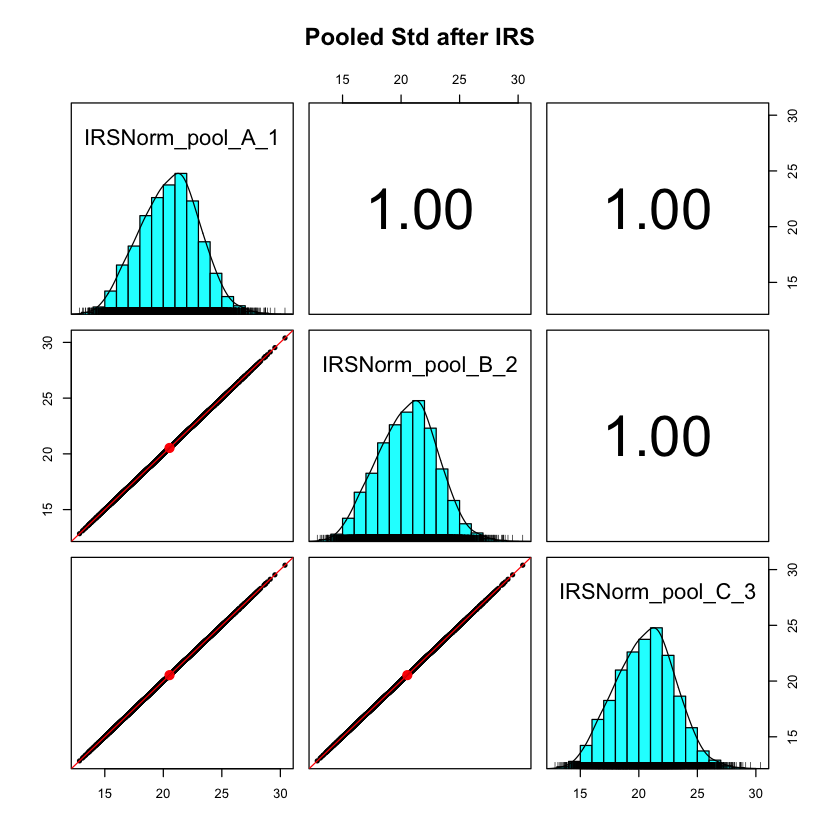

In [5]:
# multi-panel scatter plot grids from the psych package
pairs.panels(log2(sl_pool), lm = TRUE, main = "Pooled Std before IRS")
pairs.panels(log2(irs_pool), lm = TRUE, main = "Pooled Std after IRS")

## Scatter plots between plexes are terrible before IRS

The random sampling of MS2 scans is why the before IRS scatter plots are horrible. In this case, there was only a single pooled standard channel. The IRS procedure produces the trivial result of the standards ending up identical.

## We can also compare samples by condition before and after IRS

Since we have a lot of samples, we will randomly look at a few.

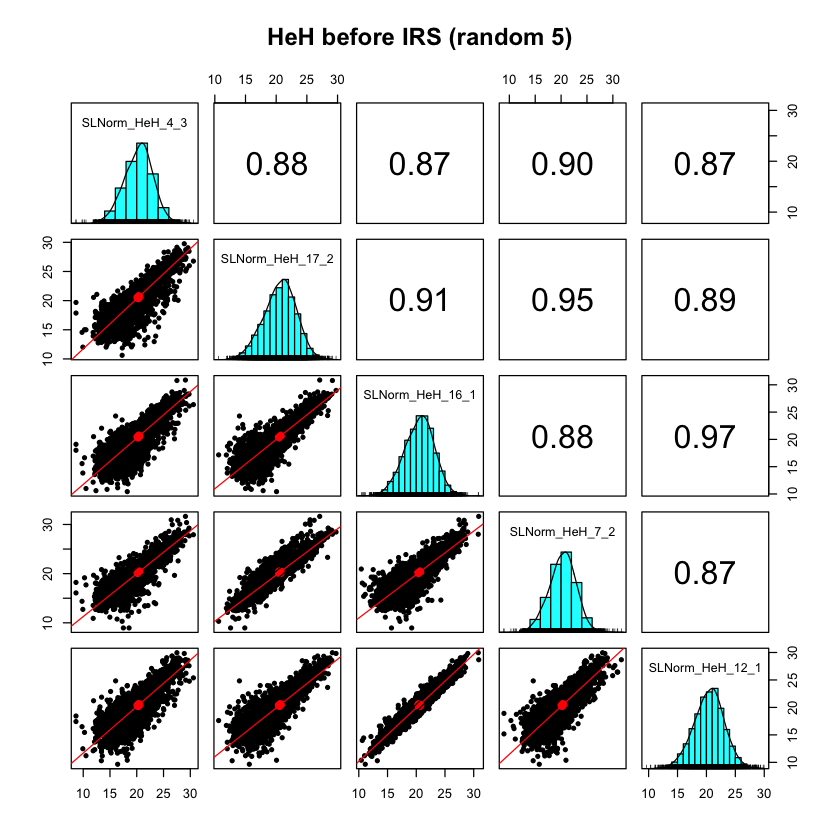

In [6]:
# multi-panel scatter plot grids
heh_sample <- sample(1:18, 5)
pairs.panels(log2(sl_HeH[heh_sample]), lm = TRUE, main = "HeH before IRS (random 5)")
pairs.panels(log2(irs_HeH[heh_sample]), lm = TRUE, main = "HeH after IRS (same 5)")

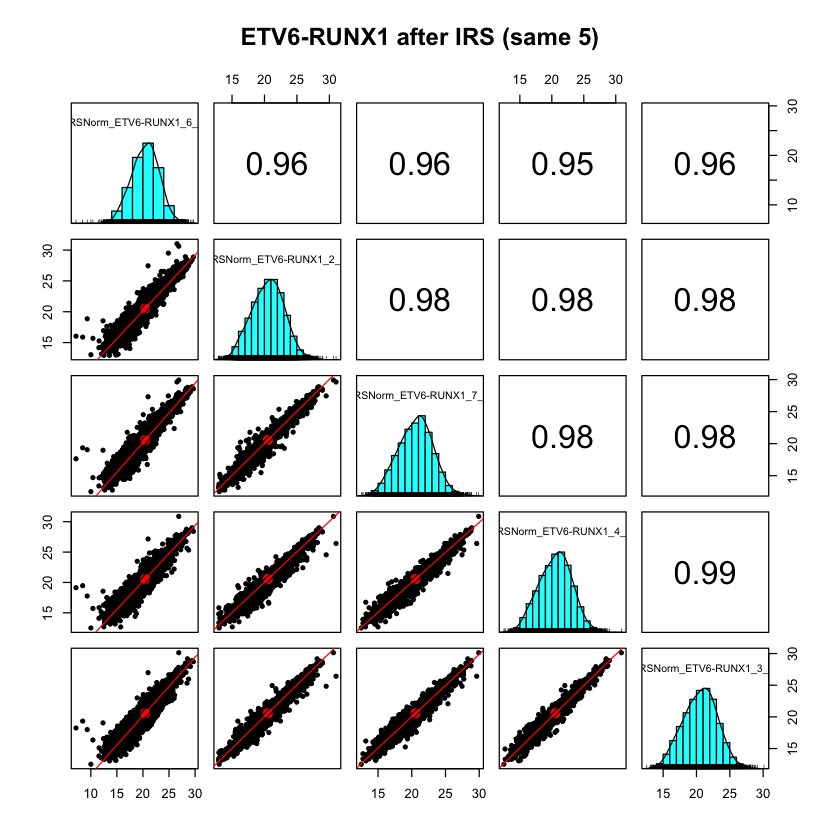

In [7]:
# multi-panel scatter plot grids
etv6_sample  <- sample(1:9, 5)
pairs.panels(log2(sl_ETV6[etv6_sample]), lm = TRUE, main = "ETV6-RUNX1 before IRS (random 5)")
pairs.panels(log2(irs_ETV6[etv6_sample]), lm = TRUE, main = "ETV6-RUNX1 after IRS (same 5)")

### The IRS method is working well

## EdgeR has another very useful data visualization
A multi-dimensional scaling plot (similar to hierarchical clustering or PCA plots) is a good way to check the data. We should expect the samples to group by condition. We can do the clustering before and after IRS to verify that we are able to recovery the true biological differences between groups. We need to load the data into some edgeR data structures and make a couple of function calls to generate the cluster plots.

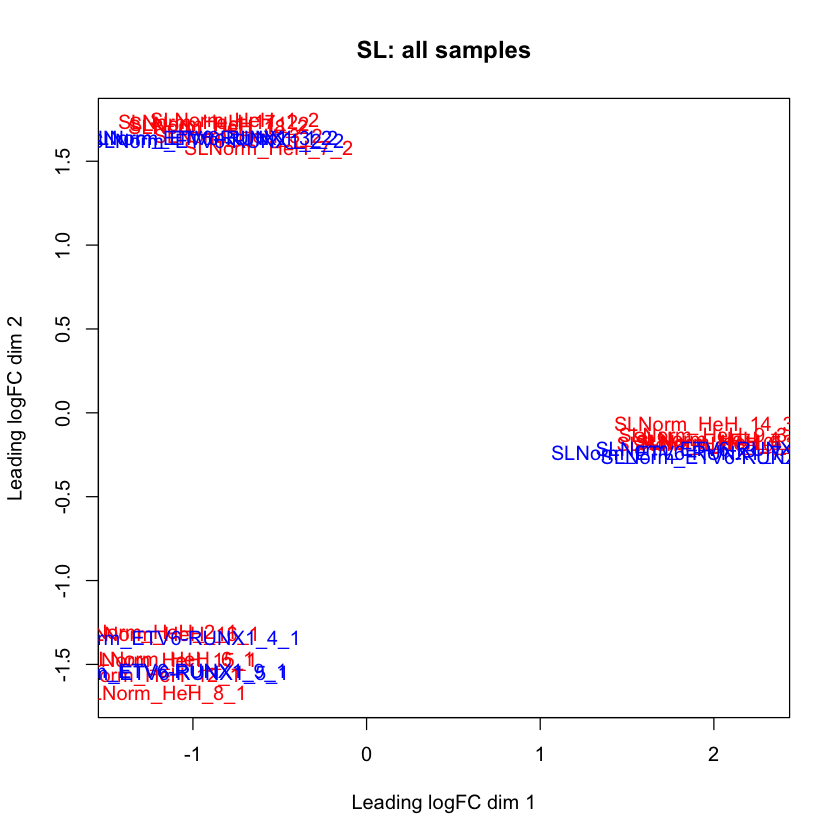

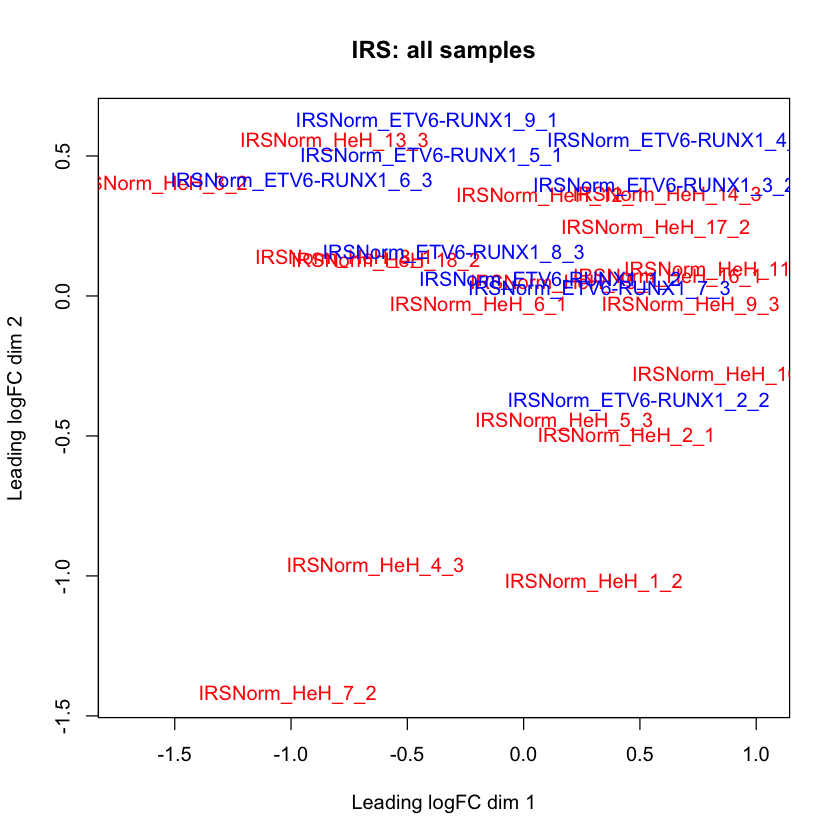

In [8]:
# get the biological sample data into a DGEList object
group = c(rep('HeH', 18), rep('ETV6', 9))
y_sl <- DGEList(counts = cbind(sl_HeH, sl_ETV6), group = group, genes = accessions)
y_irs <- DGEList(counts = cbind(irs_HeH, irs_ETV6), group = group, genes = accessions)

# run TMM normalization (also includes a library size factor)
y_sl <- calcNormFactors(y_sl)
y_irs <- calcNormFactors(y_irs)

# set some colors by condition
colors = c(rep('red', 18), rep('blue', 9))

# check the clustering
plotMDS(y_sl, col = colors, main = "SL: all samples")
plotMDS(y_irs, col = colors, main = "IRS: all samples")

## Samples cluster by TMT experiment without IRS correction

The **top** MDS plot shows the first TMT experiment on the left and the second experiment on the right. After IRS, (**bottom** plot) we have the biological-condition clustering. 

## Load IRS normalized data into edgeR DGEList object <a name="load_edger"></a>
We need to get the data into some edgeR objects to work with. We do not want to include the pooled standard channels with the biological sample channels for the edgeR testing. The pooled standards are technical replicates and have a very different variance behavior compared to the biological replicates. We can call the calcNormFactors function to perform library size and the trimmed mean of M-values (TMM) normalization. EdgeR combines these two normalizations into one function call. The library size corrections are somewhat redundant because that was done as part of the IRS procedure. The TMM normalization was designed for 'omics data and it makes sense to apply that after we have done the IRS correction. The TMM normalization corrects for compositional differences between biological conditions. If some abundant proteins change expression, since we have equal total amounts of protein per sample, that will make all other protein abundances change to compensate. TMM normalization will detect and correct these situations.

> Robinson, M.D. and Oshlack, A., 2010. A scaling normalization method for differential expression analysis of RNA-seq data. Genome biology, 11(3), p.R25.

In [9]:
# we do not want the technical replicates in the mix for dispersion estimates
irs <- cbind(irs_HeH, irs_ETV6)

# load a new DGEList object (need to update the groups)
y <- DGEList(counts = irs, group = group, genes = accessions) # group was set above
y <- calcNormFactors(y)

# see what the normalization factors look like
y$samples

group lib.size    norm.factors
IRSNorm_HeH_8_1        HeH   59619828066 0.9146174   
IRSNorm_HeH_15_1       HeH   59174770158 0.9801277   
IRSNorm_HeH_16_1       HeH   59608283019 1.0247233   
IRSNorm_HeH_6_1        HeH   59537186010 1.0073280   
IRSNorm_HeH_12_1       HeH   58988444937 1.0022933   
IRSNorm_HeH_2_1        HeH   59996613302 1.0281536   
IRSNorm_HeH_7_2        HeH   61510917649 0.7926808   
IRSNorm_HeH_3_2        HeH   59189889343 0.8608550   
IRSNorm_HeH_1_2        HeH   59868517536 0.9831244   
IRSNorm_HeH_17_2       HeH   59010412558 1.0702483   
IRSNorm_HeH_11_2       HeH   59552669044 1.0664418   
IRSNorm_HeH_18_2       HeH   59015517278 1.0066820   
IRSNorm_HeH_13_3       HeH   58930362301 0.9908508   
IRSNorm_HeH_4_3        HeH   59701498568 0.9546003   
IRSNorm_HeH_14_3       HeH   59631303692 1.0668805   
IRSNorm_HeH_9_3        HeH   59258327409 1.0382841   
IRSNorm_HeH_10_3       HeH   57474551022 0.9407580   
IRSNorm_HeH_5_3        HeH   59534747292 0.8979951   
IRSNorm_ETV6-RUNX1_9_1 ETV6  59977538876 1.0503010   
IRSNorm_ETV6-RUNX1_5_1 ETV6  59568769926 1.0333809   
IRSNorm_ETV6-RUNX1_4_1 ETV6  60339199972 1.0703053   
IRSNorm_ETV6-RUNX1_1_2 ETV6  59136246932 1.0193570   
IRSNorm_ETV6-RUNX1_3_2 ETV6  59187507856 1.0907702   
IRSNorm_ETV6-RUNX1_2_2 ETV6  59640281370 1.0362072   
IRSNorm_ETV6-RUNX1_8_3 ETV6  58658439711 1.0556895   
IRSNorm_ETV6-RUNX1_7_3 ETV6  59708308094 1.0656529   
IRSNorm_ETV6-RUNX1_6_3 ETV6  59779183923 1.0208058

## EdgeR normalization factors are mostly close to 1

Unless we have biological conditions with large compositional differences, we expect the library sizes and normalization factors after the calcNormFactors call to be around 1.0.

## Compute and save the normalized intensities
The visualizations in this notebook are informative, but we ultimately have to share the experimental results with the scientific community. It is important to be able to examine the underlying data that generates all of these plots. We can use the edgeR normalization factors to produce the TMM normalized data that is what the statistical testing will be working with. EdgeR uses the normalization factors in its statistical modeling but does not output the normalized intensities. We have to compute the normalized intensities by hand below. We will save the normalized data as the first part of a **results** data frame that we can write out at the end of the analysis.

In [10]:
# Compute the normalized intensities (start with the IRS data)
# sample loading adjusts each channel to the same average total
lib_facs <- mean(colSums(irs)) / colSums(irs)

# print("Sample loading normalization factors")
print("Library size factors")
round(lib_facs, 4)

# the TMM factors are library adjustment factors (so divide by them)
norm_facs <- lib_facs / y$samples$norm.factors

# print these final correction factors
print("Combined (lib size and TMM) normalization factors")
round(norm_facs, 4)

# compute the normalized data as a new data frame
results <- sweep(irs, 2, norm_facs, FUN = "*")
colnames(results) <- str_c(colnames(results), "_TMMnorm") # add suffix to col names
# head(results) # check that the column headers are okay

[1] "Library size factors"


IRSNorm_HeH_8_1       IRSNorm_HeH_15_1       IRSNorm_HeH_16_1 
                0.9974                 1.0049                 0.9976 
       IRSNorm_HeH_6_1       IRSNorm_HeH_12_1        IRSNorm_HeH_2_1 
                0.9988                 1.0081                 0.9912 
       IRSNorm_HeH_7_2        IRSNorm_HeH_3_2        IRSNorm_HeH_1_2 
                0.9668                 1.0047                 0.9933 
      IRSNorm_HeH_17_2       IRSNorm_HeH_11_2       IRSNorm_HeH_18_2 
                1.0077                 0.9986                 1.0076 
      IRSNorm_HeH_13_3        IRSNorm_HeH_4_3       IRSNorm_HeH_14_3 
                1.0091                 0.9961                 0.9972 
       IRSNorm_HeH_9_3       IRSNorm_HeH_10_3        IRSNorm_HeH_5_3 
                1.0035                 1.0347                 0.9989 
IRSNorm_ETV6-RUNX1_9_1 IRSNorm_ETV6-RUNX1_5_1 IRSNorm_ETV6-RUNX1_4_1 
                0.9915                 0.9983                 0.9855 
IRSNorm_ETV6-RUNX1_1_2 IRSNorm_ETV6-RUNX1_3_2 IRSNorm_ETV6-RUNX1_2_2 
                1.0056                 1.0047                 0.9971 
IRSNorm_ETV6-RUNX1_8_3 IRSNorm_ETV6-RUNX1_7_3 IRSNorm_ETV6-RUNX1_6_3 
                1.0138                 0.9960                 0.9948

[1] "Combined (lib size and TMM) normalization factors"


IRSNorm_HeH_8_1       IRSNorm_HeH_15_1       IRSNorm_HeH_16_1 
                1.0905                 1.0253                 0.9736 
       IRSNorm_HeH_6_1       IRSNorm_HeH_12_1        IRSNorm_HeH_2_1 
                0.9915                 1.0058                 0.9640 
       IRSNorm_HeH_7_2        IRSNorm_HeH_3_2        IRSNorm_HeH_1_2 
                1.2196                 1.1671                 1.0103 
      IRSNorm_HeH_17_2       IRSNorm_HeH_11_2       IRSNorm_HeH_18_2 
                0.9416                 0.9363                 1.0010 
      IRSNorm_HeH_13_3        IRSNorm_HeH_4_3       IRSNorm_HeH_14_3 
                1.0184                 1.0434                 0.9347 
       IRSNorm_HeH_9_3       IRSNorm_HeH_10_3        IRSNorm_HeH_5_3 
                0.9665                 1.0998                 1.1123 
IRSNorm_ETV6-RUNX1_9_1 IRSNorm_ETV6-RUNX1_5_1 IRSNorm_ETV6-RUNX1_4_1 
                0.9440                 0.9660                 0.9208 
IRSNorm_ETV6-RUNX1_1_2 IRSNorm_ETV6-RUNX1_3_2 IRSNorm_ETV6-RUNX1_2_2 
                0.9865                 0.9211                 0.9622 
IRSNorm_ETV6-RUNX1_8_3 IRSNorm_ETV6-RUNX1_7_3 IRSNorm_ETV6-RUNX1_6_3 
                0.9603                 0.9346                 0.9745

## Check the normalizations with box plots <a name="norm_check"></a>
Box plots for well normalized data should be similar in size and the medians should align with each other. There can be problems with the data that may not be apparent with boxplots (some data distortions can average out and not appear different with boxplots). Regardless, we should have boxplots with good median alignment. Good boxplot behavior is a necessary but not sufficient requirement of proper normalization. 

We will use ggplot2 this time and flip the graph on its side, so we can read the labels easier. We need tidy (long form) data for ggplot:

In [11]:
long_results <- gather(results, key = "sample", value = "intensity") %>%
  mutate(log_int = log10(intensity)) %>%
  extract(sample, into = 'group', ".*?_(.*?)_", remove = FALSE)
head(long_results)

sample                  group intensity log_int 
1 IRSNorm_HeH_8_1_TMMnorm HeH   401318202 8.603489
2 IRSNorm_HeH_8_1_TMMnorm HeH   108572654 8.035720
3 IRSNorm_HeH_8_1_TMMnorm HeH   841831615 8.925225
4 IRSNorm_HeH_8_1_TMMnorm HeH   542030277 8.734024
5 IRSNorm_HeH_8_1_TMMnorm HeH   628794866 8.798509
6 IRSNorm_HeH_8_1_TMMnorm HeH   505296417 8.703546

In [12]:
ggplot(long_results, aes(x = sample, y = log_int, fill = group)) +
  geom_boxplot(notch = TRUE) +
  coord_flip() + 
  ggtitle("edgeR normalized data")

## Compare to standard boxplot function

ggplot2 groups the distributions by the sample groups and does the colors automatically. The standard boxplot is easy to call. We have samples grouped and the color vector already defined.

In [13]:
# look at normalized intensity distributions for each sample
boxplot(log10(results), col = colors,
        xlab = 'TMT samples', ylab = 'log10 Intensity', 
        main = 'edgeR normalized data', notch = TRUE)

## ggplot can easily do other plot styles

Boxplots and density plots are closely related. We can easily see the smoothed density distributions for each sample.

In [14]:
ggplot(long_results, aes(x = log_int, color = sample)) +
  geom_density() +
  guides(color = FALSE) +
  ggtitle("edgeR normalized data (with legend is too busy)")

## How reproducible are samples within conditions?

The distributions of Coefficients of Variation (CVs) are another way to get an idea of how individual proteins are behaving. This seems to be an effective way to assess proper normalization in these experiments. We will compute CV distributions for each of the two biological conditions.

In [15]:
# we can compare CVs before and after IRS
sl <- cbind(sl_HeH, sl_ETV6)

# save column indexes for different conditions (indexes to data_raw frame)
# these make things easier (and reduce the chance for errors)
HeH <- 1:18
ETV6 <- (1:9) + 18

# create a CV computing function
CV <- function(df) {
    ave <- rowMeans(df)
    sd <- apply(df, 1, sd)
    cv <- 100 * sd / ave
}

# put CVs in data frames to simplify plots and summaries
cv_frame <- data.frame(HeH.sl = CV(sl[HeH]), HeH.final = CV(results[HeH]), 
                       ETV6.sl = CV(sl[ETV6]), ETV6.final = CV(results[ETV6]))


# see what the median CV values are
medians <- apply(cv_frame, 2, FUN = median)
print("Median CVs by condition, before/after IRS (%)")
round(medians, 1)

[1] "Median CVs by condition, before/after IRS (%)"


HeH.sl  HeH.final    ETV6.sl ETV6.final 
      39.8       27.7       34.9       21.5

## Use ggplot to explore the CV data

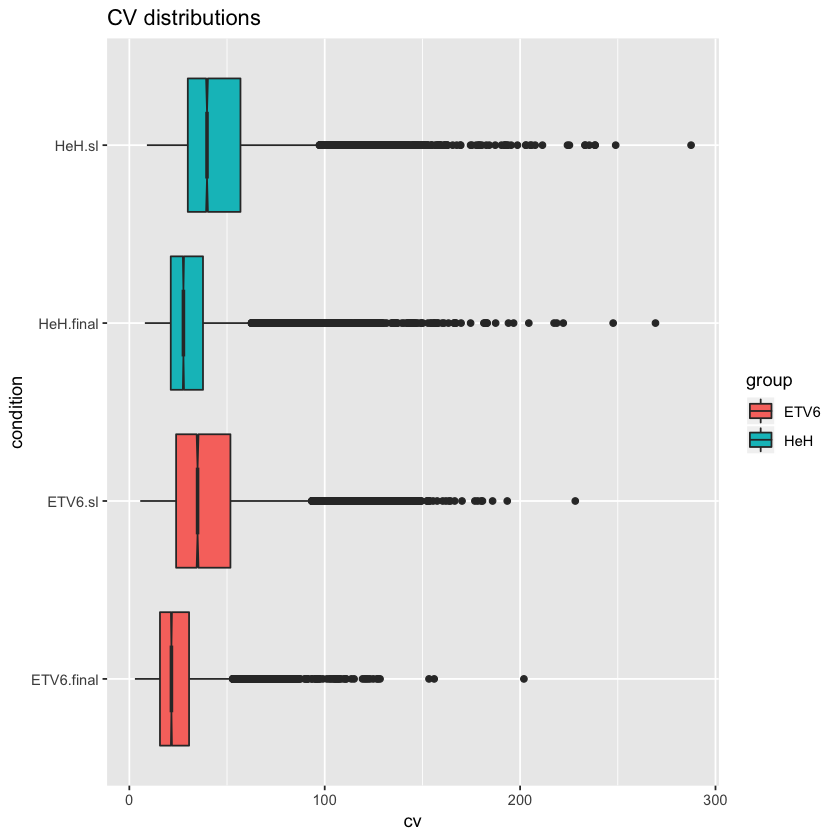

In [16]:
# see what the CV distibutions look like
# need long form for ggplot
long_cv <- gather(cv_frame, key = "condition", value = "cv") %>%
  extract(condition, into = 'group', "(.*?)\\.+", remove = FALSE)

# traditional boxplots
cv_plot <- ggplot(long_cv, aes(x = condition, y = cv, fill = group)) +
  geom_boxplot(notch = TRUE) +
  ggtitle("CV distributions")

# vertical orientation
cv_plot

# horizontal orientation
cv_plot + coord_flip()

# density plots
ggplot(long_cv, aes(x = cv, color = condition)) +
  geom_density() +
  coord_cartesian(xlim = c(0, 150)) +
  ggtitle("CV distributions")

## Data are improved by the normalizations

The CVs improve with IRS and TMM normalizations. The median CVs get smaller, but the distributions of the CV values are much improved with considerably smaller inter-quartile ranges. 


## Normalized data has been checked and looks okay

We have used scatter plots, correlation coefficients, clustering, and boxplots to verify that the IRS procedure and TMM normalization behaved as expected. None of the biological samples needed any excessive normalization factors or appeared as an outlier in the cluster views. Everything looks ready for statistical testing with edgeR.

----
# EdgeR statistical testing starts here
----

# Compare HeH to ETV6-RUNX1 samples <a name="HeH"></a>

## Compute the shared variance trend

One of the most powerful features of edgeR (and limma) is computing variances across larger numbers of genes (proteins) to get more robust variance estimates for small replicate experiments. Here, we have 27 samples across all conditions to use to improve the variance estimates and reduce false positive differential expression (DE) candidates. We have an edgeR estimateDisp function that does all of this and a visualization function to check the result.

We loaded the IRS data into DGEList object "y" a few cells above and did the normalization step. We need to estimate the dispersion parameters before we can do the actual statistical testing. This only needs to be done once. Each exact test will take two conditions and compare them using the normalization factors and dispersion estimates saved in "y".

In [17]:
# compute dispersions and plot BCV
y <- estimateDisp(y)
plotBCV(y, main = "BCV plot of IRS normed, TMM normed, all 27")

Design matrix not provided. Switch to the classic mode.


## Exact test of HeH to ETV6-RUNX1 using experiment-wide dispersion

We will specify the pair of interest for the exact test in edgeR and use the experiment-wide dispersion. The decideTestsDGE call will tell us how many up and down regulated candidates we have at an FDR of 0.10. The topTags call does the Benjamini-Hochberg multiple testing corrections. We save the test results in `tt`. We use a handy MA (mean-average) plotting function from limma to visualize the DE candidates, and then check the p-value distribution.

       ETV6-HeH
Down        891
NotSig     7078
Up          787

Comparison of groups:  ETV6-HeH 
                           genes      logFC     logCPM       PValue
2753        sp|Q92784|DPF3_HUMAN  2.0682297  6.0285897 1.004637e-64
481        sp|Q9NZI8|IF2B1_HUMAN  3.1073441  8.6329312 8.508252e-63
4599       sp|Q9UI15|TAGL3_HUMAN  2.2786360  4.3784212 2.082512e-39
3993       sp|O43374|RASL2_HUMAN  1.8395589  5.0666865 2.917451e-37
350        sp|Q02952|AKA12_HUMAN  2.5838583  9.0763937 1.037113e-36
3311        sp|P15918|RAG1_HUMAN  2.1910096  5.5776486 3.072287e-35
6889        sp|O95208|EPN2_HUMAN  2.2684183  2.7518503 1.623029e-31
5131       sp|Q2M1K9|ZN423_HUMAN  1.3358806  4.2580075 5.791637e-31
5372       sp|Q52LW3|RHG29_HUMAN  1.9230381  4.1086490 1.000881e-30
3977        sp|O15264|MK13_HUMAN  1.5498301  5.0538592 1.105511e-29
7515       sp|P07711|CATL1_HUMAN  2.1781019  1.6968253 3.963492e-27
7863       sp|Q9NR80|ARHG4_HUMAN  1.4983440  1.5971703 1.748320e-26
5612       sp|Q9BXM9|FSD1L_HUMAN  1.3797873  3.9820444 2.683459e-25
8547       sp|Q8TCN5|ZN507_HUMAN  1.7778858 -0.1825862 9.193343e-25
8103       sp|Q92952|KCNN1_HUMAN  2.1689264  0.2485182 9.814177e-22
7304       sp|Q96A56|T53I1_HUMAN  2.0211685  2.4068738 2.868174e-21
4593       sp|Q9NZA1|CLIC5_HUMAN  1.9077938  4.6092914 2.107172e-20
6138       sp|Q9Y4F1|FARP1_HUMAN  1.6035065  3.3339181 3.727253e-20
3046       sp|Q5T7W0|ZN618_HUMAN  1.0363154  5.7057873 9.128261e-19
1167        sp|O00764|PDXK_HUMAN -1.3280120  7.4175956 1.155612e-18
1222       sp|Q06210|GFPT1_HUMAN  1.2520230  7.4065986 4.224386e-18
236         sp|P33241|LSP1_HUMAN -1.5232836  9.4446283 4.639092e-18
2381       sp|P19174|PLCG1_HUMAN  1.2676773  6.2235407 8.490894e-18
3378        sp|Q96JQ2|CLMN_HUMAN  1.1904904  5.5724943 1.371771e-17
713        sp|Q14194|DPYL1_HUMAN  2.3914312  8.1763752 5.922891e-17
1305        sp|Q8WWM9|CYGB_HUMAN  1.6871038  7.2890393 1.230968e-16
5158       sp|O75363|BCAS1_HUMAN  1.9286247  4.2063844 1.188130e-15
7025       sp|Q2KJY2|KI26B_HUMAN  1.7191325  2.3724962 2.200480e-15
1262       sp|Q9UEW8|STK39_HUMAN  1.2314858  7.2280674 2.409706e-15
6857       sp|Q8WU67|ABHD3_HUMAN  1.2663408  2.7580709 2.503242e-15
5842       sp|Q9BV23|ABHD6_HUMAN  1.1816987  3.6010776 3.067304e-15
6606        sp|Q03135|CAV1_HUMAN  1.8624007  3.0865924 1.159540e-14
2316       sp|Q9NQX4|MYO5C_HUMAN  0.9490762  6.3920986 3.310407e-14
7541        sp|P34741|SDC2_HUMAN  1.4856758  1.9058826 5.621986e-14
8419       sp|Q6ZPD9|D19L3_HUMAN  1.6457064  0.5660934 6.437322e-14
5580       sp|Q8NDA8|MROH1_HUMAN  1.2568543  3.9318497 9.147455e-14
8604        sp|Q8NAX2|KDF1_HUMAN  1.6380942 -0.6122118 9.562695e-14
6981       sp|Q17R98|ZN827_HUMAN  0.9707674  2.6920189 1.494308e-13
4540       sp|Q7Z7L1|SLN11_HUMAN  1.1064109  4.7351079 2.607648e-13
818  sp|P39880|CUX1_HUMAN_family  0.6656650  7.9864325 3.247524e-13
7341       sp|Q96G61|NUD11_HUMAN  1.7732329  2.2380582 3.373112e-13
2328       sp|O94868|FCSD2_HUMAN  0.9558167  6.3310802 3.944409e-13
7404       sp|A0PK00|T120B_HUMAN  1.2049930  2.1171509 4.995131e-13
7020       sp|Q96N16|JKIP1_HUMAN  1.5108648  2.5907000 1.434851e-12
3494       sp|P46926|GNPI1_HUMAN  1.3480297  5.3857687 2.022421e-12
7128       sp|Q96QF0|RAB3I_HUMAN  1.2365585  2.2380545 2.197697e-12
4382        sp|Q8N5W9|RFLB_HUMAN -1.1194347  4.7881673 2.332429e-12
3239       sp|Q15811|ITSN1_HUMAN -0.8560028  5.7020598 2.515043e-12
6142       sp|O94876|TMCC1_HUMAN  0.7231392  3.4137793 3.486391e-12
561        sp|Q99584|S10AD_HUMAN -1.5024163  8.4336424 3.808954e-12
              FDR
2753 8.796602e-61
481  3.724913e-59
4599 6.078160e-36
3993 6.386301e-34
350  1.816192e-33
3311 4.483490e-32
6889 2.030177e-28
5131 6.338947e-28
5372 9.737460e-28
3977 9.679855e-27
7515 3.154940e-24
7863 1.275691e-23
5612 1.807413e-22
8547 5.749779e-22
8103 5.728862e-19
7304 1.569608e-18
4593 1.085317e-17
6138 1.813102e-17
3046 4.206687e-16
1167 5.059268e-16
1222 1.761368e-15
236  1.846359e-15
2381 3.232446e-15
3378 5.004678e-15
713  2.074433e-14
1305 4.145521e-14
5158 3.853062

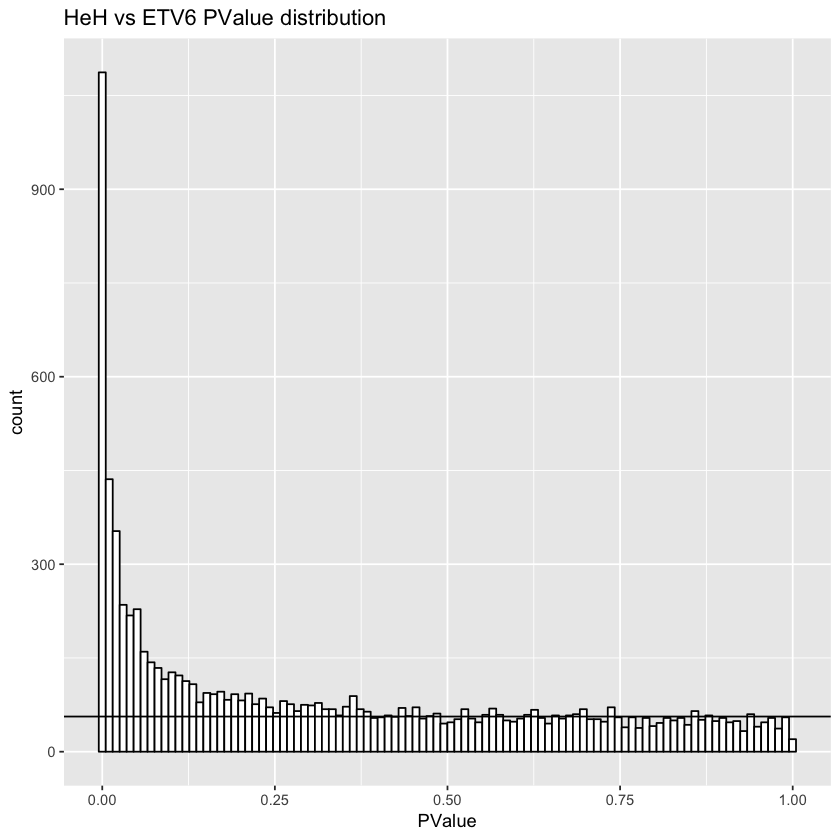

In [18]:
# the exact test object has columns like fold-change, CPM, and p-values
et <- exactTest(y, pair = c("HeH", "ETV6"))

# this counts up, down, and unchanged genes (proteins) at 10% FDR
summary(decideTestsDGE(et, p.value = 0.10))

# the topTags function adds the BH FDR values to an exactTest data frame 
# make sure we do not change the row order (the sort.by parameter)!
topTags(et, n = 50)
tt <- topTags(et, n = Inf, sort.by = "none")
tt <- tt$table    # tt is a list. We just need the "table" data frame

# make an MD plot (like MA plot)
plotMD(et, p.value = 0.10)
abline(h = c(-1, 1), col = "black")

# check the p-value distribution
ggplot(tt, aes(PValue)) + 
  geom_histogram(bins = 100, fill = "white", color = "black") + 
  geom_hline(yintercept = mean(hist(et$table$PValue, breaks = 100, 
                                    plot = FALSE)$counts[26:100])) +
  ggtitle("HeH vs ETV6 PValue distribution")

## Candidates and p-values look pretty good

The numbers of candidates are large and balanced between up and down regulation, as can be seen in the MA plot. The p-value distribution has a nice flat distribution for larger p-values (from non-DE candidates) and a sharp spike at small p-values from true DE candidates.

## Compute averages, flag candidates, and save the pair-wise test results

We will add the statistical testing results (logFC, p-values, and FDR), condition intensity averages, and candidate status to the `results` data frame (which has the TMM-normalized data).

candidate n   
1 high       658
2 med        528
3 low        492
4 no        7078

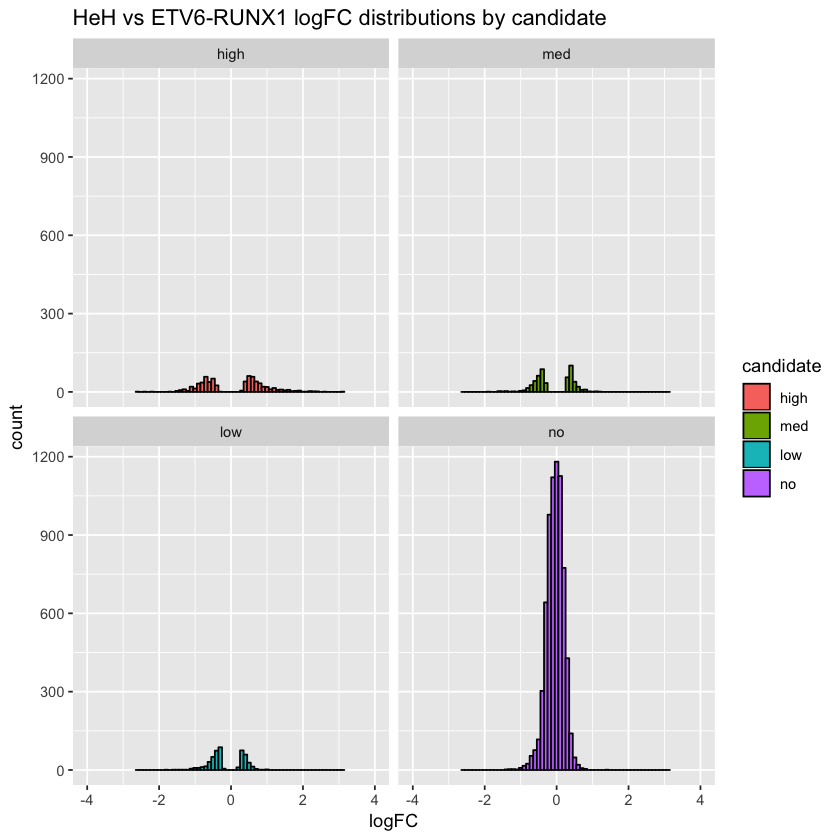

In [19]:
# get the averages within each condition 
# results already has the normalized data in its left columns
tt$ave_HeH <- rowMeans(results[HeH])
tt$ave_ETV6 <- rowMeans(results[ETV6])

# add the cadidate status column
tt <- tt %>%
  mutate(candidate = cut(FDR, breaks = c(-Inf, 0.01, 0.05, 0.10, 1.0),
  labels = c("high", "med", "low", "no")))

tt %>% count(candidate)  # count candidates

ggplot(tt, aes(x = logFC, fill = candidate)) +
  geom_histogram(binwidth=0.1, color = "black") +
  facet_wrap(~candidate) +
  coord_cartesian(xlim = c(-4, 4)) +
  ggtitle("HeH vs ETV6-RUNX1 logFC distributions by candidate")

# make column names unique by adding comparison
tt_temp  <- tt
colnames(tt_temp) <- str_c(colnames(tt), "_HE")

# add the testing results
results <- cbind(results, tt_temp)

## Main summary plots

We have many comparisons to visualize, so we will make a function to generate a series of plots. We will make: an MA plot with candidates highlighted by color, faceted MA plots separated by candidate status, a scatter plot with candidates highlighted by color, faceted scatter plots separated by candidate status, and a volcano plot with candidates highlighted by color.

In [20]:
de_plots <- function(tt, x, y, title) {
  temp <- data.frame(log10((tt[x] + tt[y])/2), 
                     log2(tt[y] / tt[x]), 
                     tt$candidate,
                     -log10(tt$FDR))
  colnames(temp) <- c("A", "M", "candidate", "P")
    
  ma_lines <- list(geom_hline(yintercept = 0.0, color = "black"),
                   geom_hline(yintercept = 1.0, color = "black", linetype = "dotted"),
                   geom_hline(yintercept = -1.0, color = "black", linetype = "dotted"))

    scatter_lines <- list(geom_abline(intercept = 0.0, slope = 1.0, color = "black"),
                          geom_abline(intercept = 0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          geom_abline(intercept = -0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          scale_y_log10(),
                          scale_x_log10())
    
  # make main MA plot
  first  <- ggplot(temp, aes(x = A, y = M)) +
    geom_point(aes(color = candidate, shape = candidate)) +
    scale_y_continuous(paste0("logFC (", y, "/", x, ")")) +
    scale_x_continuous("Ave_intensity") +
    ggtitle(title) + 
    ma_lines
    
  # make separate MA plots
  second <- ggplot(temp, aes(x = A, y = M)) +
    geom_point(aes(color = candidate, shape = candidate)) +
    scale_y_continuous(paste0("log2 FC (", y, "/", x, ")")) +
    scale_x_continuous("log10 Ave_intensity") +
    ma_lines +
    facet_wrap(~ candidate) +
    ggtitle(str_c(title, " (separated)"))

  # make main scatter plot
  third <- ggplot(tt, aes_string(x, y)) +
    geom_point(aes(color = candidate, shape = candidate)) +
    ggtitle(title) + 
    scatter_lines

  # make separate scatter plots
  fourth <- ggplot(tt, aes_string(x, y)) +
    geom_point(aes(color = candidate, shape = candidate)) +
    scatter_lines +
    facet_wrap(~ candidate) +
    ggtitle(str_c(title, " (separated)")) 

  # make volcano plot
  fifth <- ggplot(temp, aes(x = M, y = P)) +
    geom_point(aes(color = candidate, shape = candidate)) +
    xlab("log2 FC") +
    ylab("-log10 FDR") +
    ggtitle(str_c(title, " Volcano Plot"))
    
  print(first)
  print(second)
  print(third)
  print(fourth)
  print(fifth)
}

## DE Candidate Plots for HeH vs ETV6-RUNX1

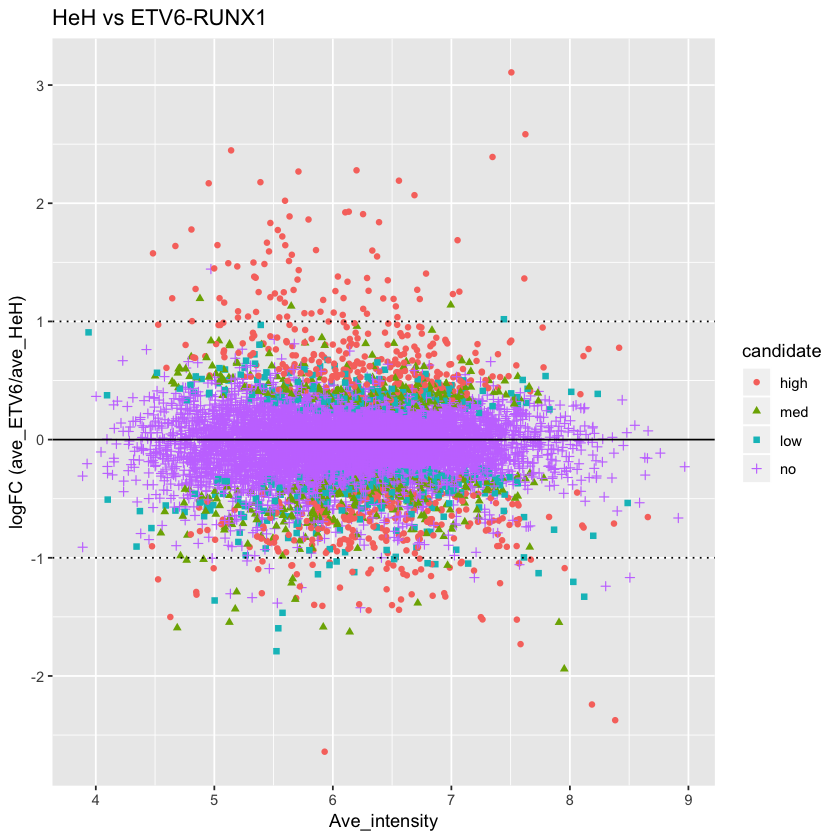

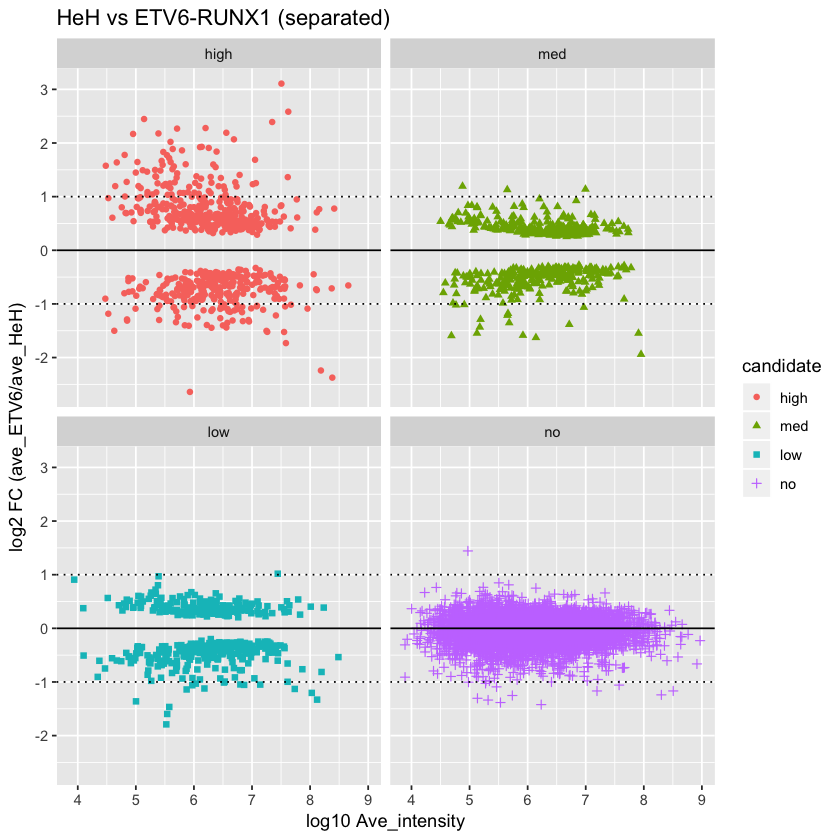

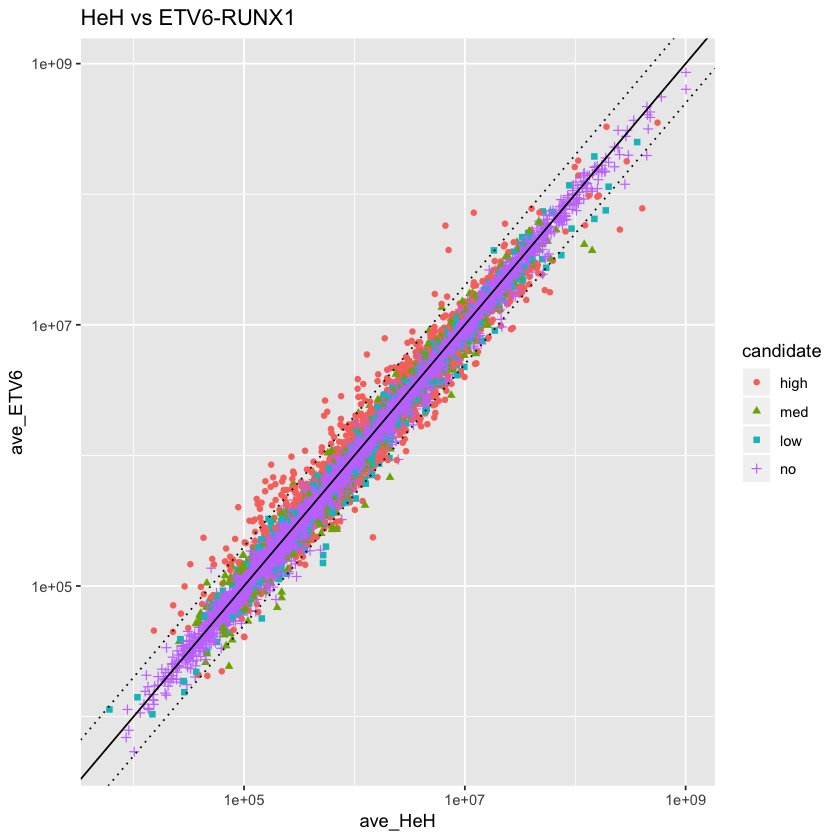

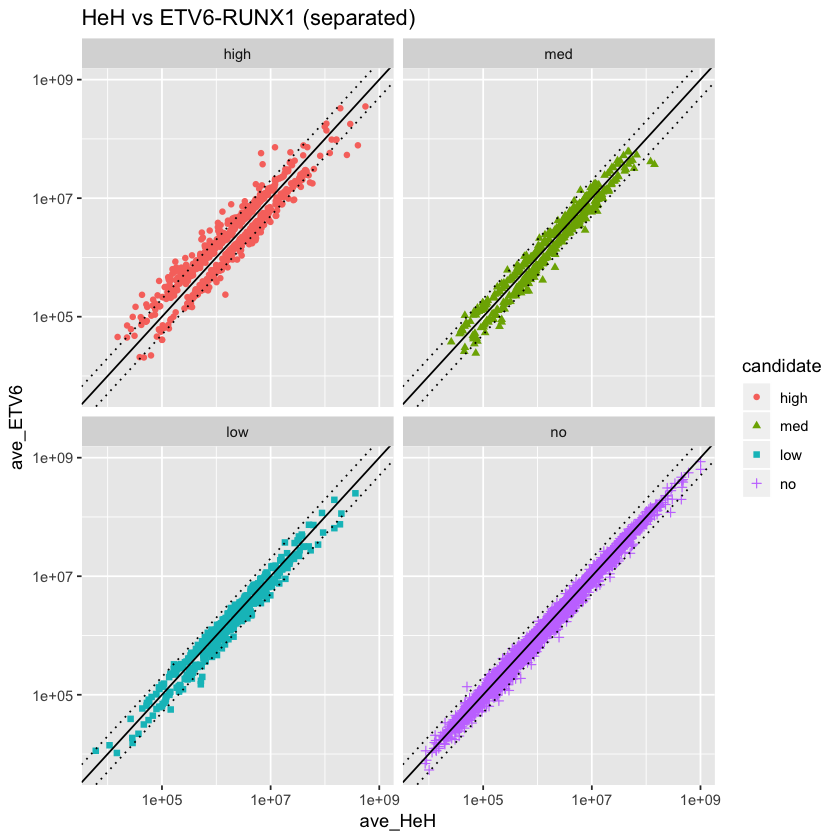

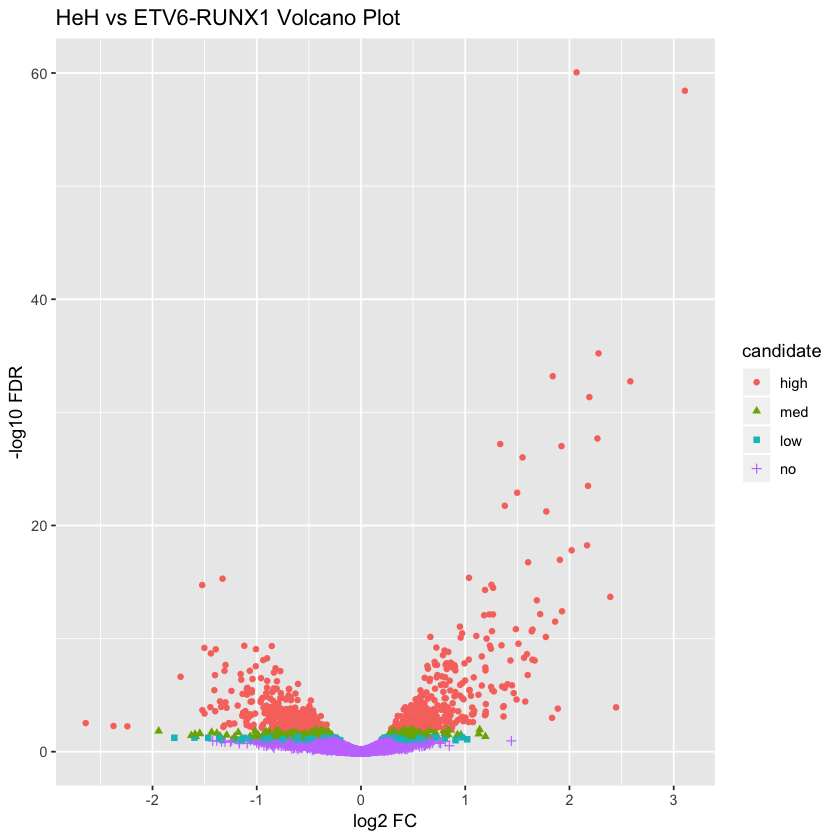

In [21]:
# make the DE plots
de_plots(tt, "ave_HeH", "ave_ETV6", "HeH vs ETV6-RUNX1")

## Many candidates are less than 2-fold

The fold-changes for candidates are not particularly large. Many of the statistically significant proteins have less than 2-fold changes. This could be due to using MS2 reporter ions instead of the newer SPS MS3 method. There are more candidates with larger fold changes that have over-expression in ETV6-RUNX1. The candidates are well spread out over the 5-decades of protein intensities.

Note: Protein total reporter ion intensity is well correlated with protein total MS1 feature intensites. In other words, it is a good relative protein abundance measure.

### Plot the reporter ions for the top 50 candidates (by FDR)

The HeH data points are in red and the ETV6-RUNX1 samples are in blue. The protein identifier, the average intensity, the individual test p-value (not the FDR), and the traditional fold-change are used as plot labels.

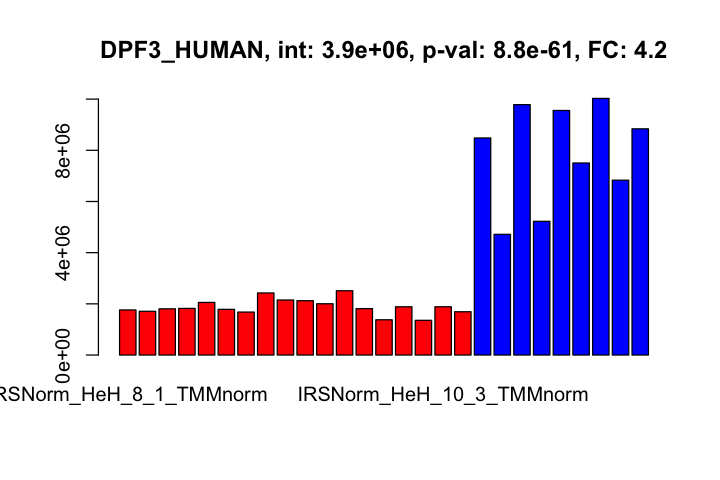

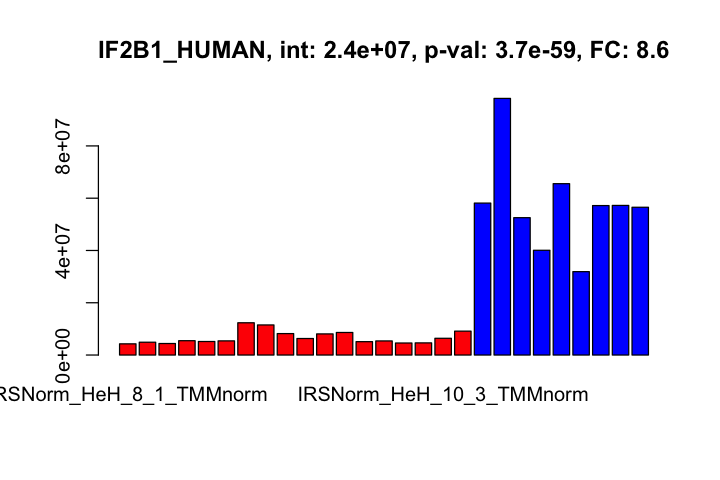

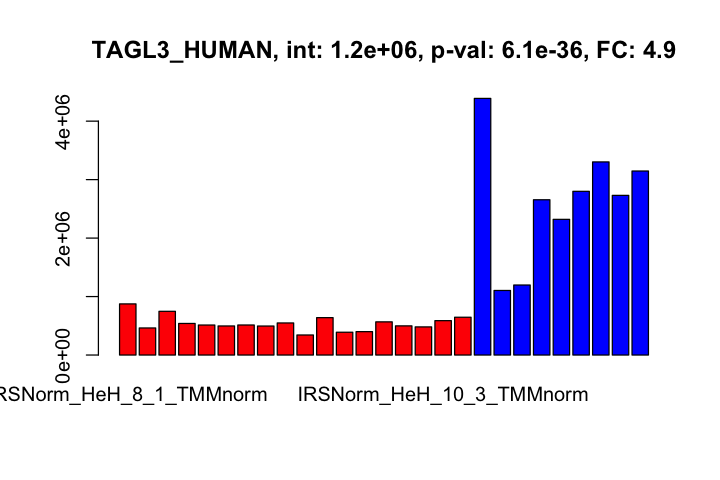

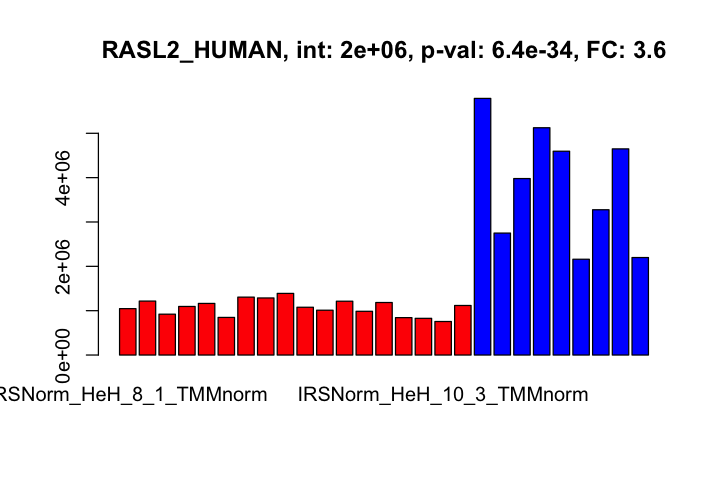

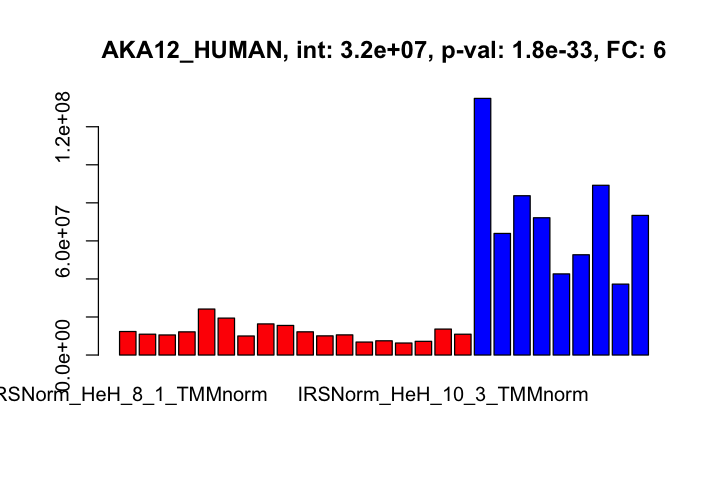

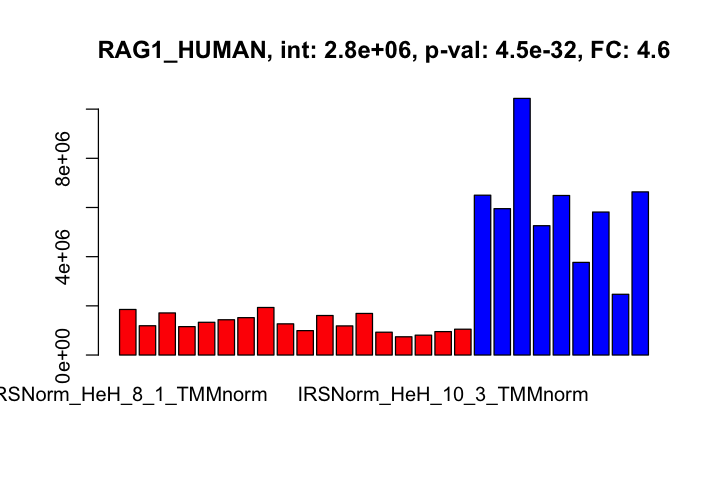

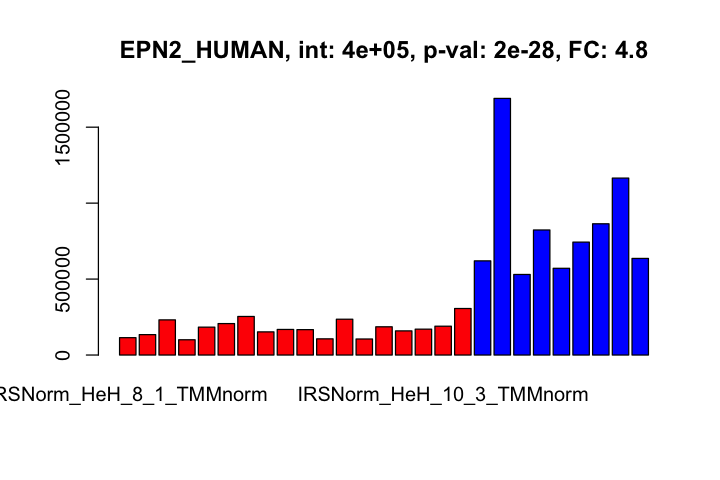

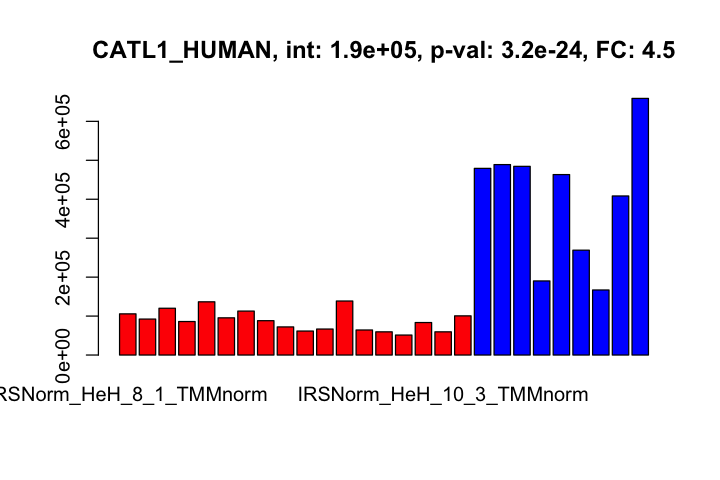

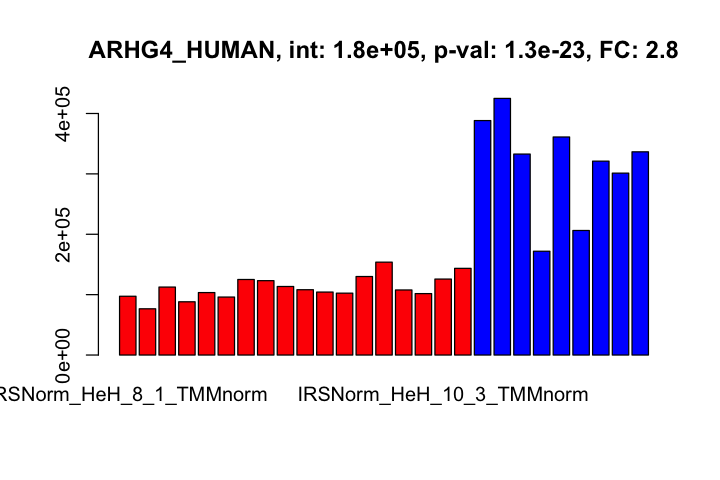

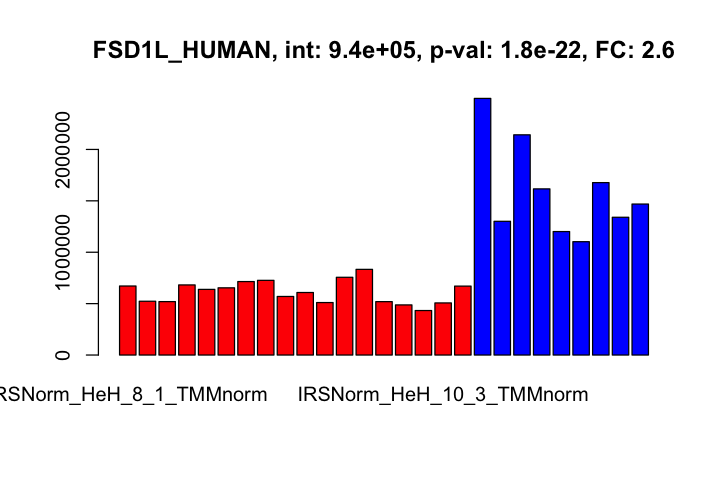

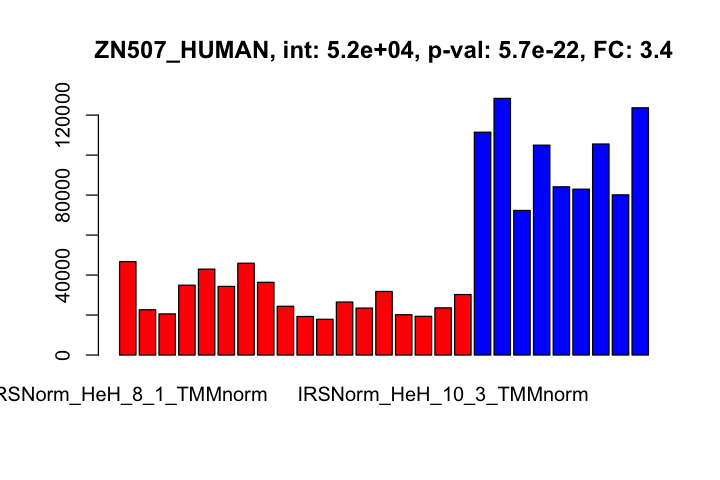

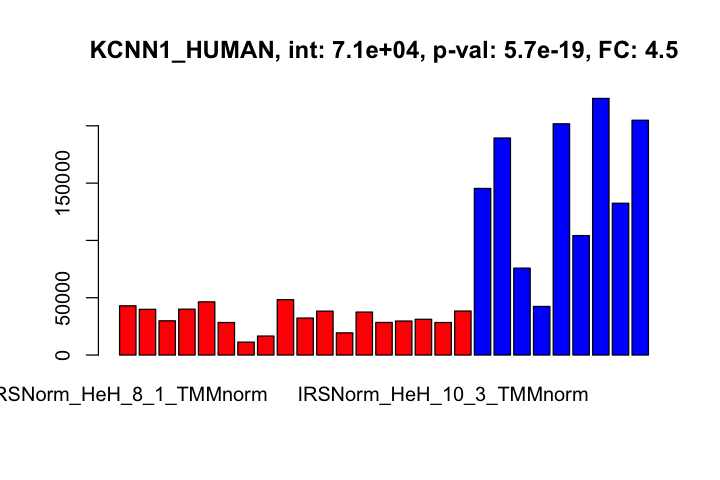

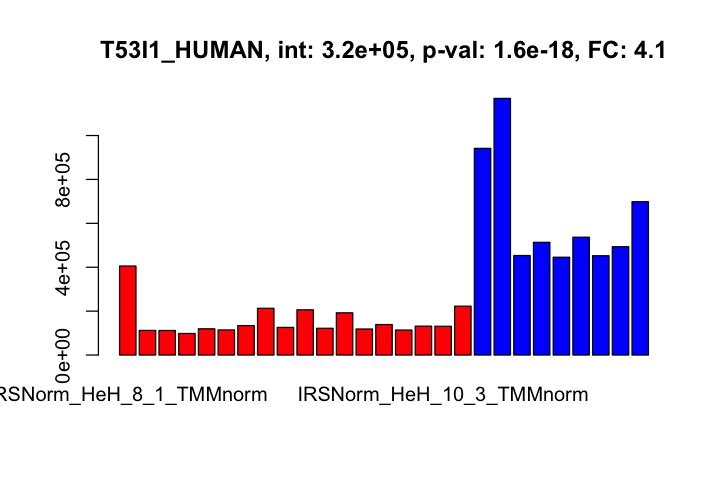

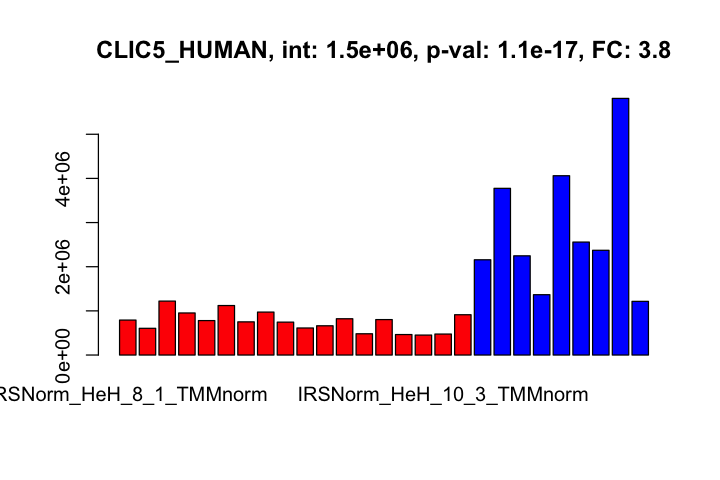

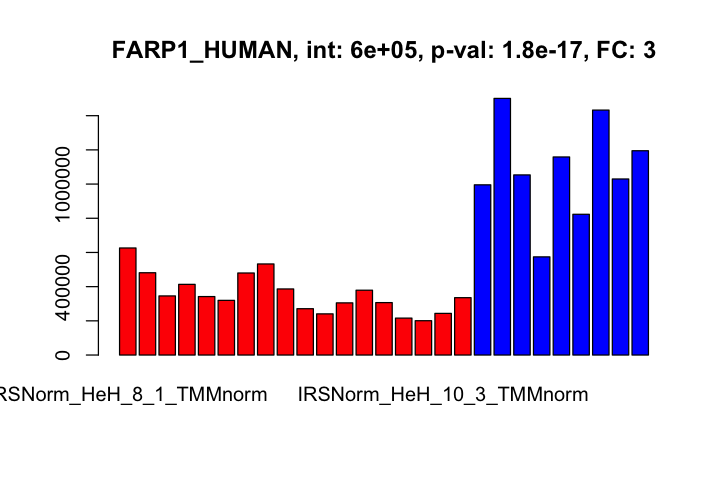

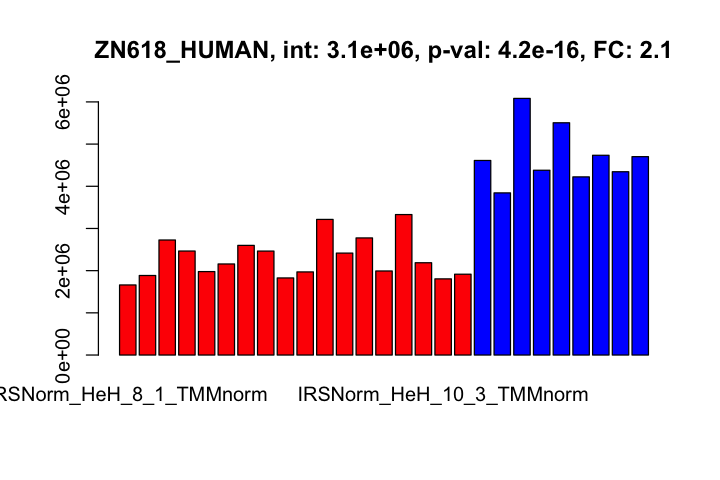

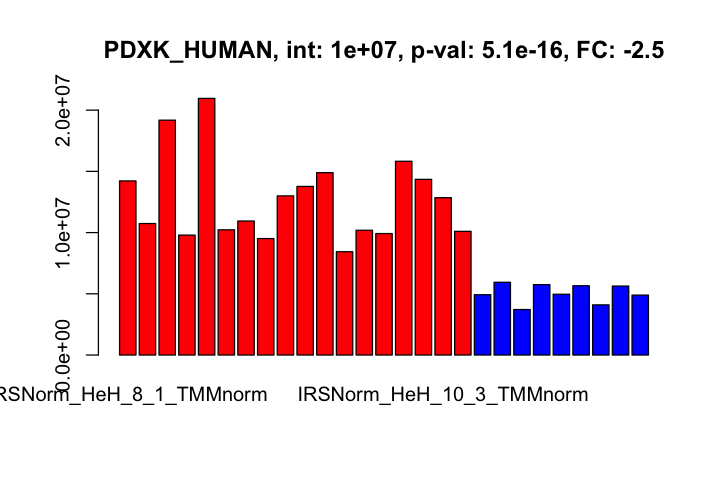

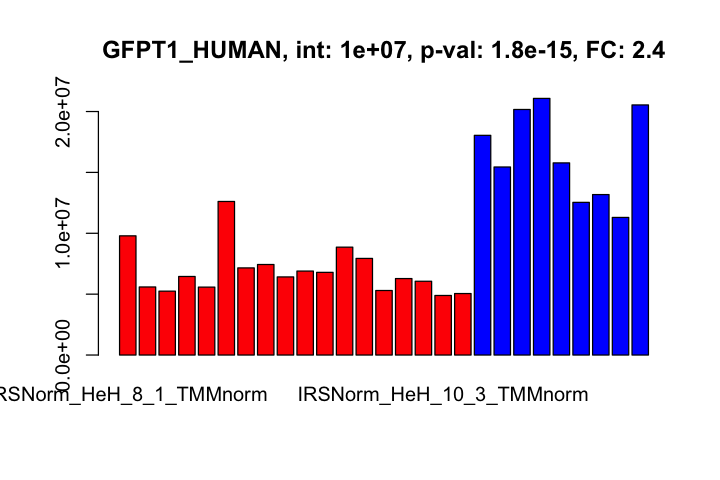

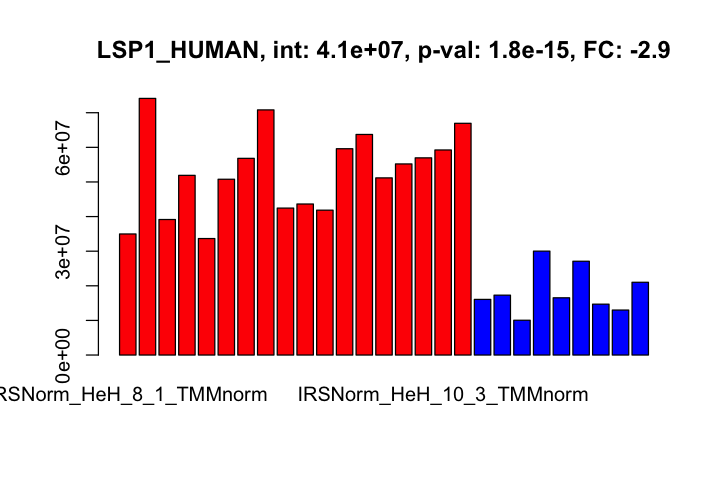

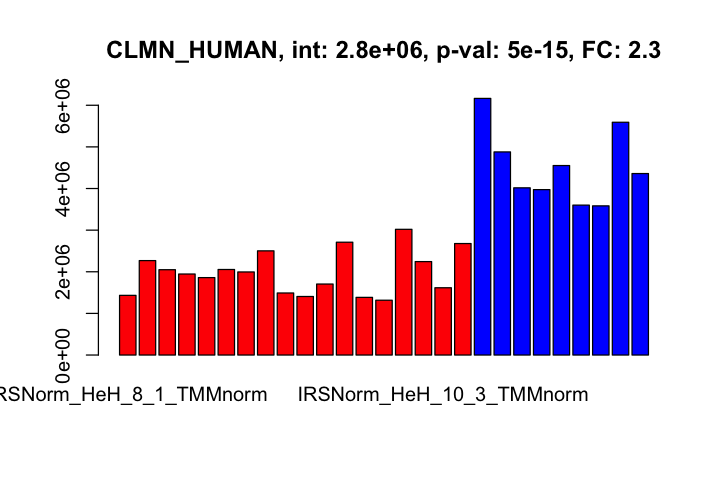

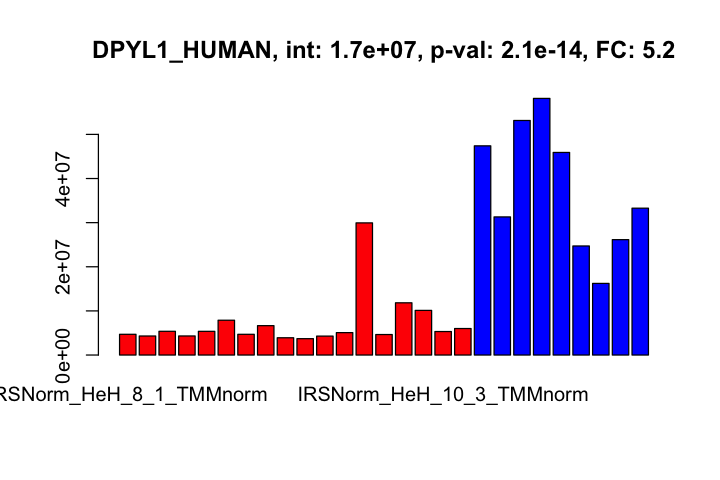

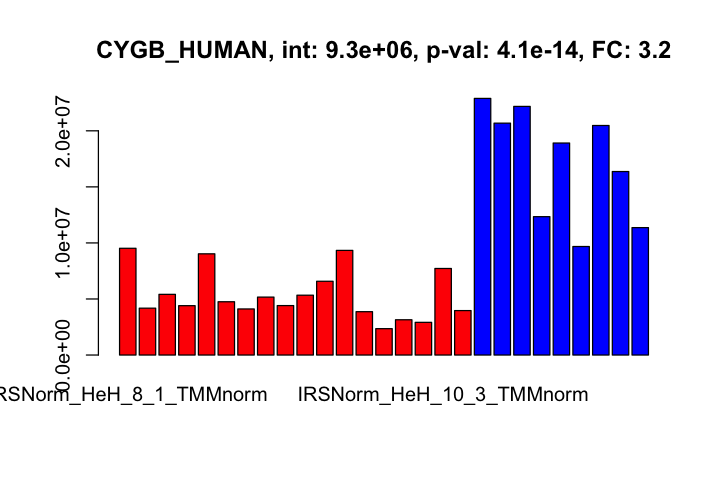

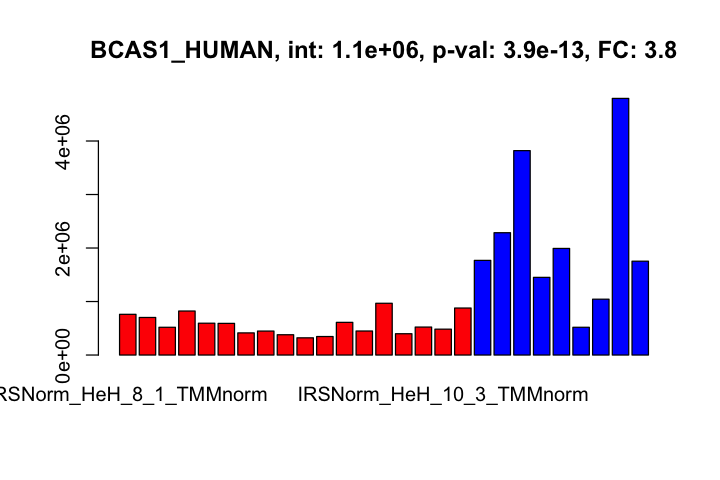

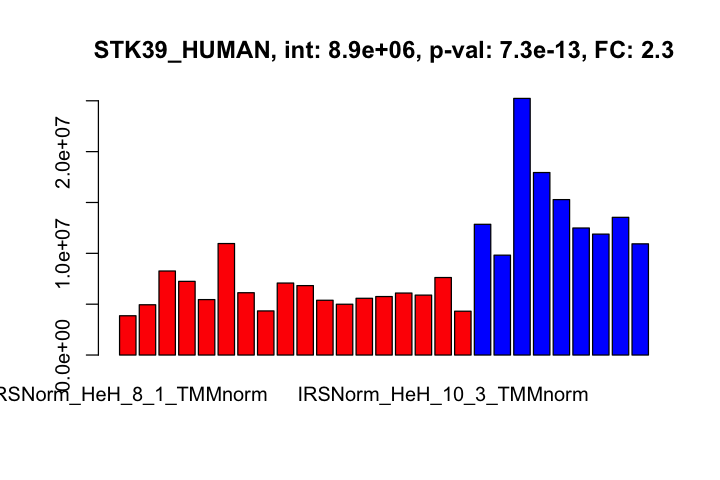

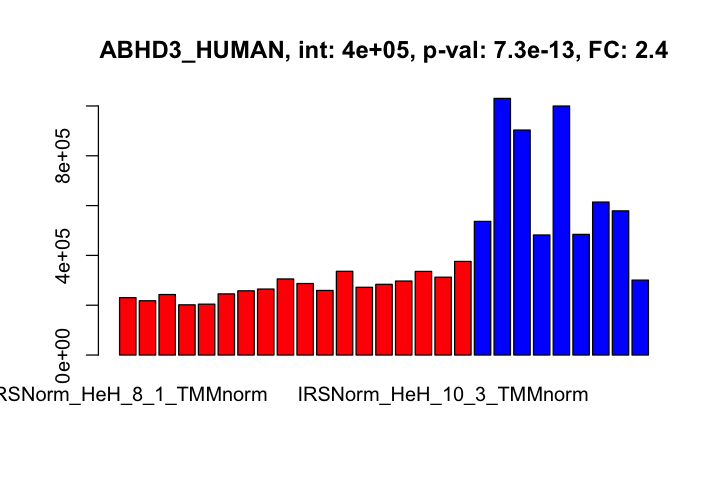

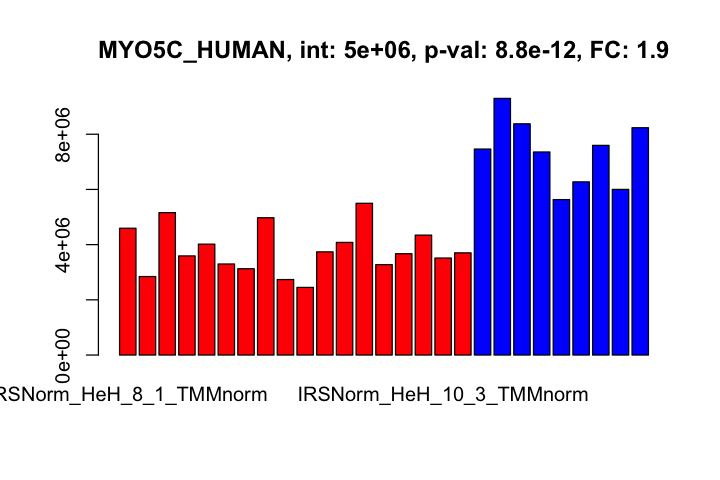

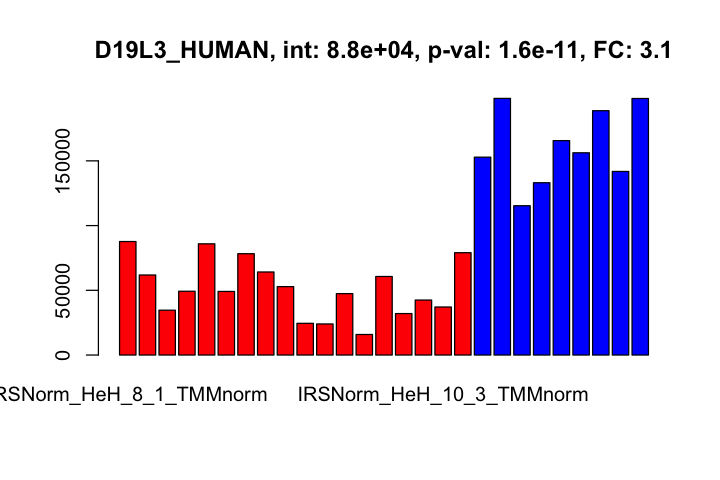

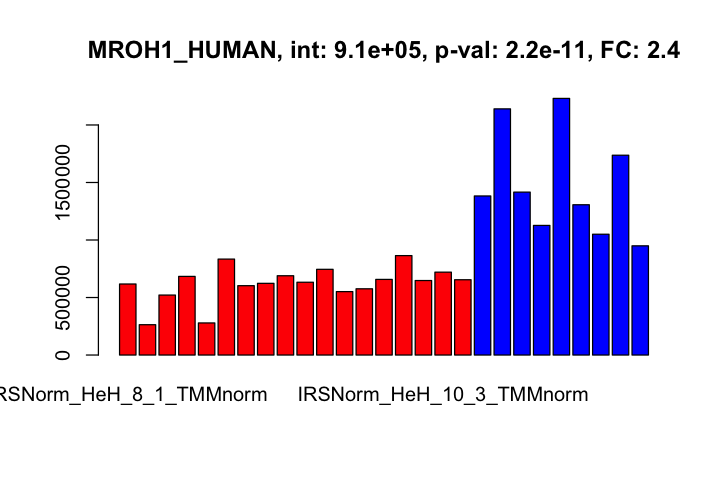

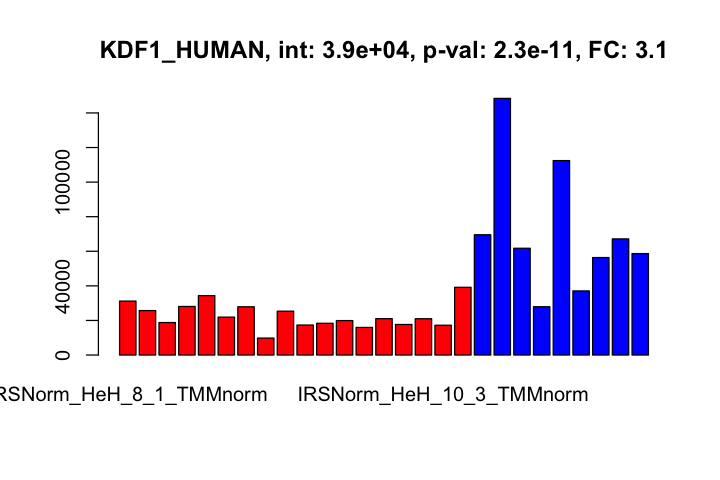

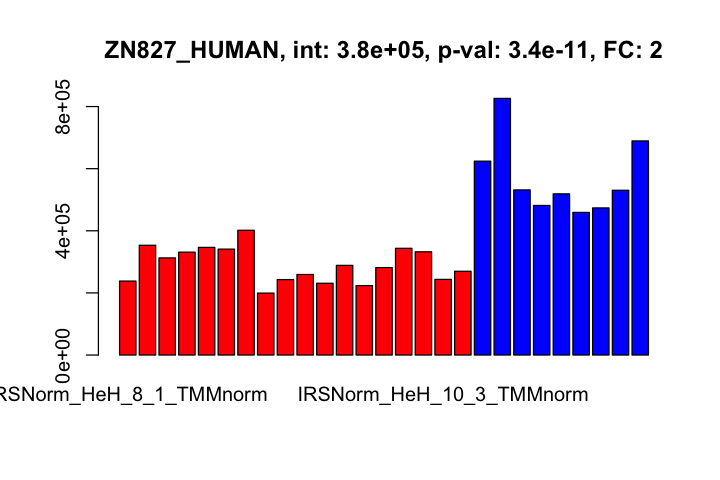

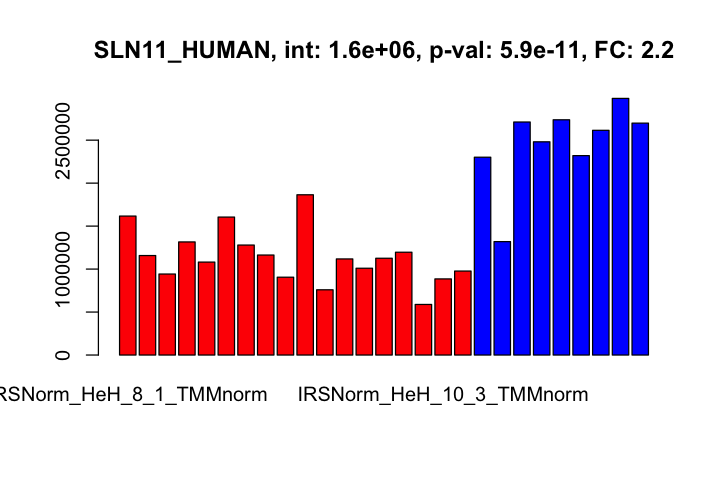

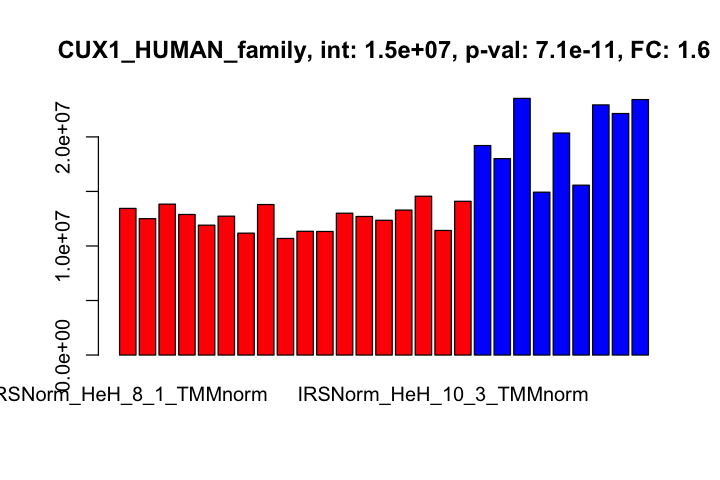

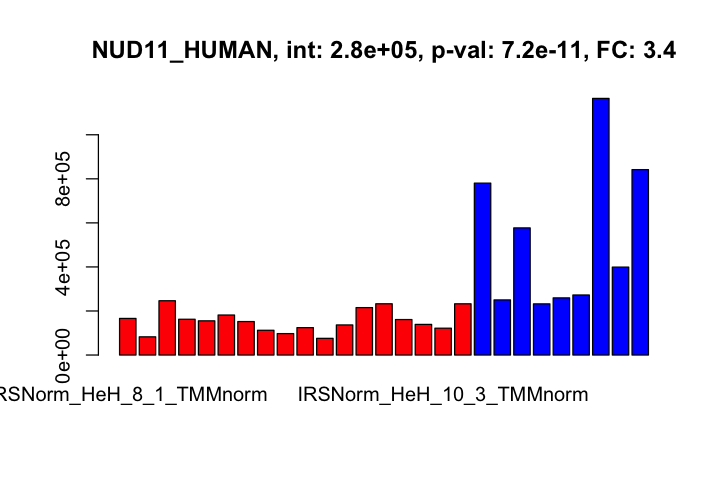

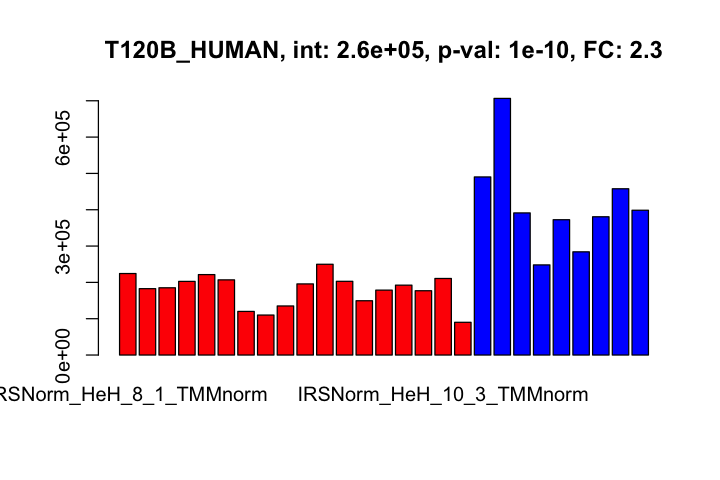

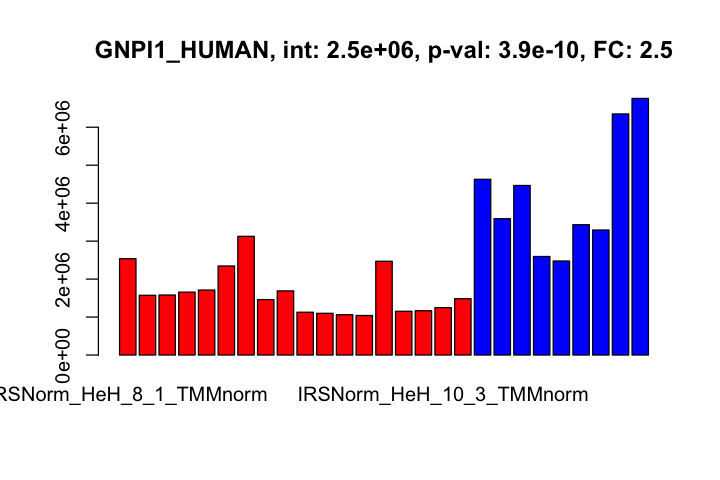

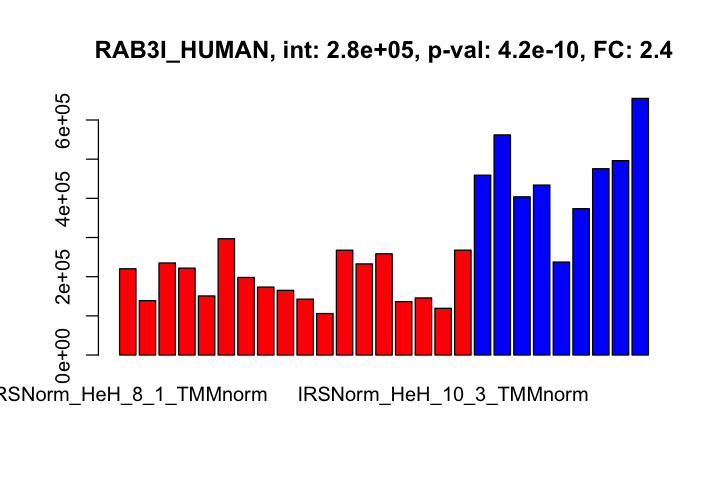

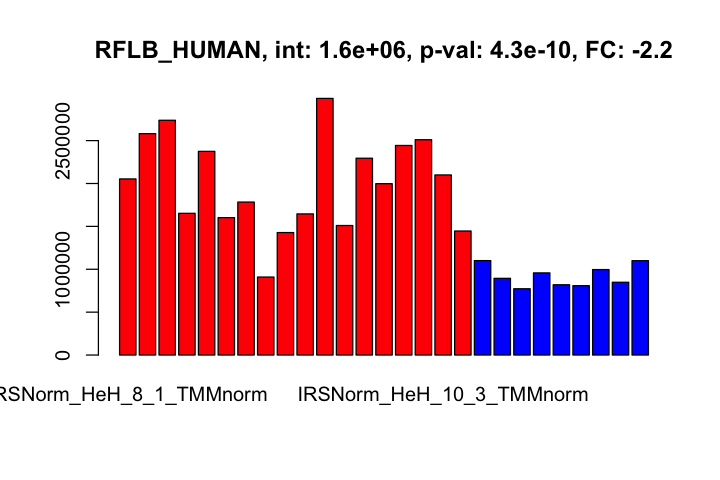

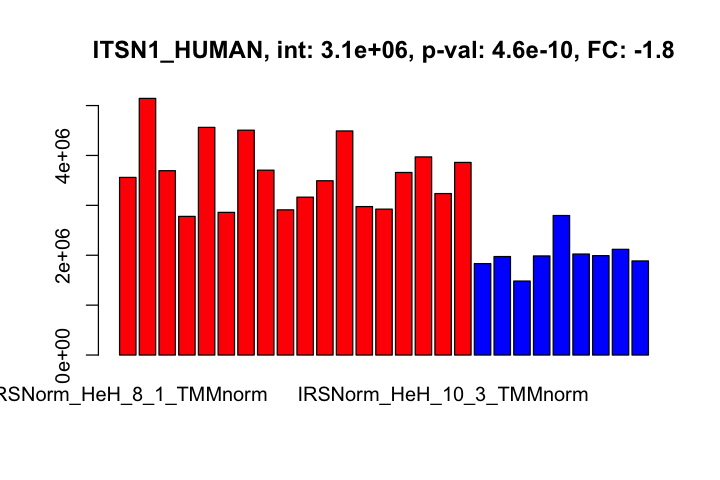

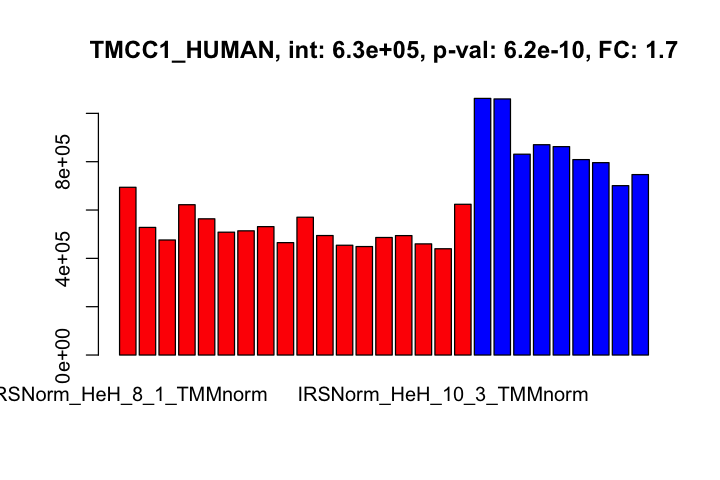

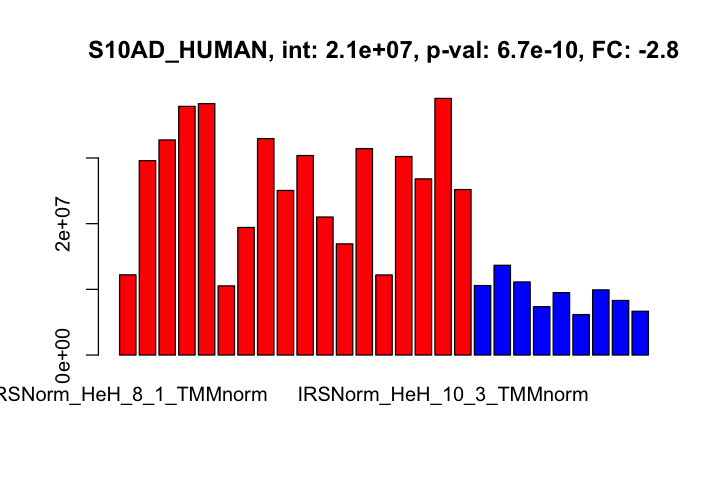

In [22]:
# ============== individual protein expression plots ===========================

# function to extract the identifier part of the accesssion
get_identifier <- function(accession) {
    identifier <- str_split(accession, "\\|", simplify = TRUE)
    identifier[,3]
}

set_plot_dimensions <- function(width_choice, height_choice) {
    options(repr.plot.width=width_choice, repr.plot.height=height_choice)
}

plot_top_tags <- function(proteins, nleft, nright, top_tags) {
    num_col <- ncol(proteins)
    top_identifiers <- get_identifier(top_tags)
    proteins <- proteins %>% 
        filter(identifier %in% top_identifiers) %>% 
        arrange(FDR)
        
    color = c(rep("red", nleft), rep("blue", nright))
    for (row_num in 1:nrow(proteins)) {
        row <- proteins[row_num, ]
        vec <- as.vector(unlist(row[4:num_col]))
        names(vec) <- colnames(row[4:num_col])
        if(row$logFC < 0) {
            FC <- -(1/(2^row$logFC))
        } else {
            FC <- 2^row$logFC
        }
        title <- str_c(row$identifier, ", int: ", scientific(mean(vec), digits = 2), 
                       ", p-val: ", scientific(row$FDR, digits = 2), 
                       ", FC: ", round(FC, digits = 1))
        barplot(vec, col = color, main = title)
    }    
}

# set up data frame
set_plot_dimensions(6, 4)
candidates <- data.frame(identifier = get_identifier(tt$genes), logFC = tt$logFC, 
                       FDR = tt$FDR, results[HeH], results[ETV6])

top_tags <- topTags(et, n = 50)$table$genes                       
plot_top_tags(candidates, length(HeH), length(ETV6), top_tags)
set_plot_dimensions(width, height)

---
## Save the `results` frame to TSV file

In [23]:
write.table(results, "IRS_R_results.txt", sep = "\t",
           row.names = FALSE, na =  " ")

## Log the session information

In [24]:
sessionInfo()

R version 3.5.3 (2019-03-11)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS Mojave 10.14.4

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] psych_1.8.12    edgeR_3.24.3    limma_3.38.3    scales_1.0.0   
 [5] forcats_0.4.0   stringr_1.4.0   dplyr_0.8.0.1   purrr_0.3.2    
 [9] readr_1.3.1     tidyr_0.8.3     tibble_2.1.1    ggplot2_3.1.0  
[13] tidyverse_1.2.1

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-3     tidyselect_0.2.5 locfit_1.5-9.1   repr_0.19.2     
 [5] splines_3.5.3    haven_2.1.0      lattice_0.20-38  colorspace_1.4-1
 [9] generics_0.0.2   htmltools_0.3.6  base64enc_0.1-3  rlang_0.3.3     
[13] pi